In [1]:
# Speech separation model.
import pandas as pd
import csv
import types
import wave 
import fnmatch

import tensorflow as tf
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import glob
import PIL
import imageio
from IPython import display

# 使用第一張與第三張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#Initialize for files name and path.
base_dir = 'E:/dataset/musan'
dataset_merge_speech_name = 'merge/speech'
dataset_merge_noise_name = 'merge/noise'
dataset_merge_mix_name = 'merge/mix'
dataset_separate_speech_name = 'separation/speech'
dataset_separate_noise_name = 'separation/noise'
model_name = 'crnn_model'

dataset_merge_speech_dir = os.path.join(base_dir, dataset_merge_speech_name)
dataset_merge_noise_dir = os.path.join(base_dir, dataset_merge_noise_name)
dataset_merge_mix_dir = os.path.join(base_dir, dataset_merge_mix_name)
dataset_separate_noise_dir = os.path.join(base_dir, dataset_separate_noise_name)
if not os.path.exists(dataset_separate_noise_dir):
    os.makedirs(dataset_separate_noise_dir)
dataset_separate_speech_dir = os.path.join(base_dir, dataset_separate_speech_name)
if not os.path.exists(dataset_separate_speech_dir):
    os.makedirs(dataset_separate_speech_dir)
model_dir = os.path.join(base_dir, model_name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [2]:
# Audio parameter
channel_num = 1
sampling = 16000 #Hz
sampwidth = 2 #byte
frame_size = 256
fft_size = frame_size // 2 + 1
step_ratio = 2
frame_step = frame_size // step_ratio
frame_width = 7
frame_center = 3

int2float = 32768.0
train_rate = 0.8
data_len = len(fnmatch.filter(os.listdir(dataset_merge_speech_dir), '*.wav'))
train_len = int(data_len * train_rate)
rand_data = np.random.permutation(data_len)
train_idx = rand_data[:train_len]
test_idx = rand_data[train_len:]
hann_in = np.hanning(frame_size) * 2.0  / int2float

train_x_dataset = []
train_y1_dataset = []
train_y2_dataset = []
test_x_dataset = []
test_y1_dataset = []
test_y2_dataset = []
total_idx = 0
start_time = time.time()

buffer_x = np.zeros((fft_size, frame_width), dtype=np.float32)
buffer_y1 = np.zeros((fft_size, frame_width), dtype=np.float32)
buffer_y2 = np.zeros((fft_size, frame_width), dtype=np.float32)
        
for idx in train_idx:
    speech_name = 'merge_speech_librivox_%05d.wav' % idx
    merge_speech_dir = os.path.join(dataset_merge_speech_dir, speech_name)
    merge_speech_wave = wave.open(merge_speech_dir, "rb")
    merge_speech_params = merge_speech_wave.getparams()
    merge_speech_nchannels, merge_speech_sampwidth, merge_speech_framerate, merge_speech_nframes = merge_speech_params[:4]
    merge_speech_strData = merge_speech_wave.readframes(merge_speech_nframes)
    merge_speech_Data = np.fromstring(merge_speech_strData, dtype=np.int16)
    merge_speech_wave.close()
    
    noise_name = 'merge_noise_librivox_%05d.wav' % idx
    merge_noise_dir = os.path.join(dataset_merge_noise_dir, noise_name)
    merge_noise_wave = wave.open(merge_noise_dir, "rb")
    merge_noise_params = merge_noise_wave.getparams()
    merge_noise_nchannels, merge_noise_sampwidth, merge_noise_framerate, merge_noise_nframes = merge_noise_params[:4]
    merge_noise_strData = merge_noise_wave.readframes(merge_noise_nframes)
    merge_noise_Data = np.fromstring(merge_noise_strData, dtype=np.int16)
    merge_noise_wave.close()
    
    frame_length = merge_speech_nframes//frame_step - step_ratio + 1
    for step in range(frame_length):
        sample = step * frame_step
        sub_idx = step % frame_width
        merge_speech_frame = merge_speech_Data[sample:sample + frame_size] // 2
        buffer_y1[:,sub_idx] = np.absolute(np.fft.fft(hann_in * merge_speech_frame)[:fft_size])
        merge_noise_frame = merge_noise_Data[sample:sample + frame_size] // 2
        buffer_y2[:,sub_idx] = np.absolute(np.fft.fft(hann_in * merge_noise_frame)[:fft_size])
        merge_mix_frame = merge_speech_frame + merge_noise_frame
        buffer_x[:,sub_idx] = np.absolute(np.fft.fft(hann_in * merge_mix_frame)[:fft_size])
        
        if sub_idx is frame_width - 1:
            train_x_dataset.append(buffer_x + 1e-6)
            train_y1_dataset.append(buffer_y1[:,frame_center:frame_center+1] + 0.)
            train_y2_dataset.append(buffer_y2[:,frame_center:frame_center+1] + 0.)
            total_idx += 1
            print('\r', 'Training dataset generated number: %d' % total_idx, end='')
print('\n', 'Training is %d second passed... ' % (time.time() - start_time))
print('Training dataset total generated number: %d' % total_idx)

total_idx = 0
start_time = time.time()

for idx in test_idx:
    speech_name = 'merge_speech_librivox_%05d.wav' % idx
    merge_speech_dir = os.path.join(dataset_merge_speech_dir, speech_name)
    merge_speech_wave = wave.open(merge_speech_dir, "rb")
    merge_speech_params = merge_speech_wave.getparams()
    merge_speech_nchannels, merge_speech_sampwidth, merge_speech_framerate, merge_speech_nframes = merge_speech_params[:4]
    merge_speech_strData = merge_speech_wave.readframes(merge_speech_nframes)
    merge_speech_Data = np.fromstring(merge_speech_strData, dtype=np.int16)
    merge_speech_wave.close()
    
    noise_name = 'merge_noise_librivox_%05d.wav' % idx
    merge_noise_dir = os.path.join(dataset_merge_noise_dir, noise_name)
    merge_noise_wave = wave.open(merge_noise_dir, "rb")
    merge_noise_params = merge_noise_wave.getparams()
    merge_noise_nchannels, merge_noise_sampwidth, merge_noise_framerate, merge_noise_nframes = merge_noise_params[:4]
    merge_noise_strData = merge_noise_wave.readframes(merge_noise_nframes)
    merge_noise_Data = np.fromstring(merge_noise_strData, dtype=np.int16)
    merge_noise_wave.close()
    
    frame_length = merge_speech_nframes//frame_step - step_ratio + 1
    for step in range(frame_length):
        sample = step * frame_step
        sub_idx = step % frame_width
        merge_speech_frame = merge_speech_Data[sample:sample + frame_size] // 2
        buffer_y1[:,sub_idx] = np.absolute(np.fft.fft(hann_in * merge_speech_frame)[:fft_size])
        merge_noise_frame = merge_noise_Data[sample:sample + frame_size] // 2
        buffer_y2[:,sub_idx] = np.absolute(np.fft.fft(hann_in * merge_noise_frame)[:fft_size])
        merge_mix_frame = merge_speech_frame + merge_noise_frame
        buffer_x[:,sub_idx] = np.absolute(np.fft.fft(hann_in * merge_mix_frame)[:fft_size])
        
        if sub_idx is frame_width - 1:
            test_x_dataset.append(buffer_x + 1e-6)
            test_y1_dataset.append(buffer_y1[:,frame_center:frame_center+1] + 0.)
            test_y2_dataset.append(buffer_y2[:,frame_center:frame_center+1] + 0.)
            total_idx += 1
            print('\r', 'Testing dataset generated number: %d' % total_idx, end='')
print('\n', 'Testing is %d second passed... ' % (time.time() - start_time))
print('Testing dataset total generated number: %d' % total_idx)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


 Training dataset generated number: 1006368
 Training is 2459 second passed... 
Training dataset total generated number: 1006368
 Testing dataset generated number: 5

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


 Testing dataset generated number: 249617
 Testing is 689 second passed... 
Testing dataset total generated number: 249617


In [6]:
class DNN(tf.keras.Model):
    def __init__(self, batch_size):
        super(DNN, self).__init__()
        self.batch_size = batch_size
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(fft_size, frame_width, 1), dtype=tf.float64),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units=fft_size*frame_width, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                #tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(units=fft_size*frame_width*2, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                #tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Reshape(target_shape=(fft_size, frame_width, 2)),
            ]
        )

        self.generative1_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(fft_size, frame_width, 1), dtype=tf.float64),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units=fft_size*frame_width, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                #tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(units=fft_size, kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                #tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Reshape(target_shape=(fft_size, 1, 1)),
            ]
        )
        
        self.generative2_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(fft_size, frame_width, 1), dtype=tf.float64),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(units=fft_size*frame_width, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                #tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(units=fft_size, kernel_regularizer=tf.keras.regularizers.l2(l=0.1)),
                #tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Reshape(target_shape=(fft_size, 1, 1)),
            ]
        )
    def noise_reduction(self, x):
        y_merge = self.inference_net(x)
        y_shape = tf.shape(y_merge)
        slice_shape = [y_shape[0], y_shape[1], y_shape[2], 1]
        y1 = self.generative1_net(tf.slice(y_merge,[0, 0, 0, 0], slice_shape))
        y2 = self.generative2_net(tf.slice(y_merge,[0, 0, 0, 1], slice_shape))
        return y1, y2

In [4]:
#optimizer = tf.keras.optimizers.Adam(1e-4)
optimizer = tf.keras.optimizers.SGD(1e-4)
gamma = 0.01

def compute_loss(model, x, y1, y2):
    y1_out, y2_out = model.noise_reduction(x)
    
    return tf.reduce_mean(tf.square(y1_out - y1) + tf.square(y2_out - y2) - gamma * (tf.square(y2_out - y1) + tf.square(y1_out - y2)))

def compute_gradients(model, x, y1, y2):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, y1, y2)
    return tape.gradient(loss, model.trainable_variables), loss

def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

W0501 21:46:25.252187 17348 base.py:270] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x000002602DEE4748> and <tensorflow.python.keras.layers.core.Dropout object at 0x000002602DEE46D8>).
W0501 21:46:25.257175 17348 base.py:270] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x0000026181E316D8> and <tensorflow.python.keras.layers.core.Dropout object at 0x0000026181E27630>).
W0501 21:46:25.261164 1734

 Epoch 13 , loss 0.064780 , 449 sec (99%).
 Epoch: 13, Test set ELBO: 0.0648505836725235, time elapse for current epoch 507.5801341533661[s]



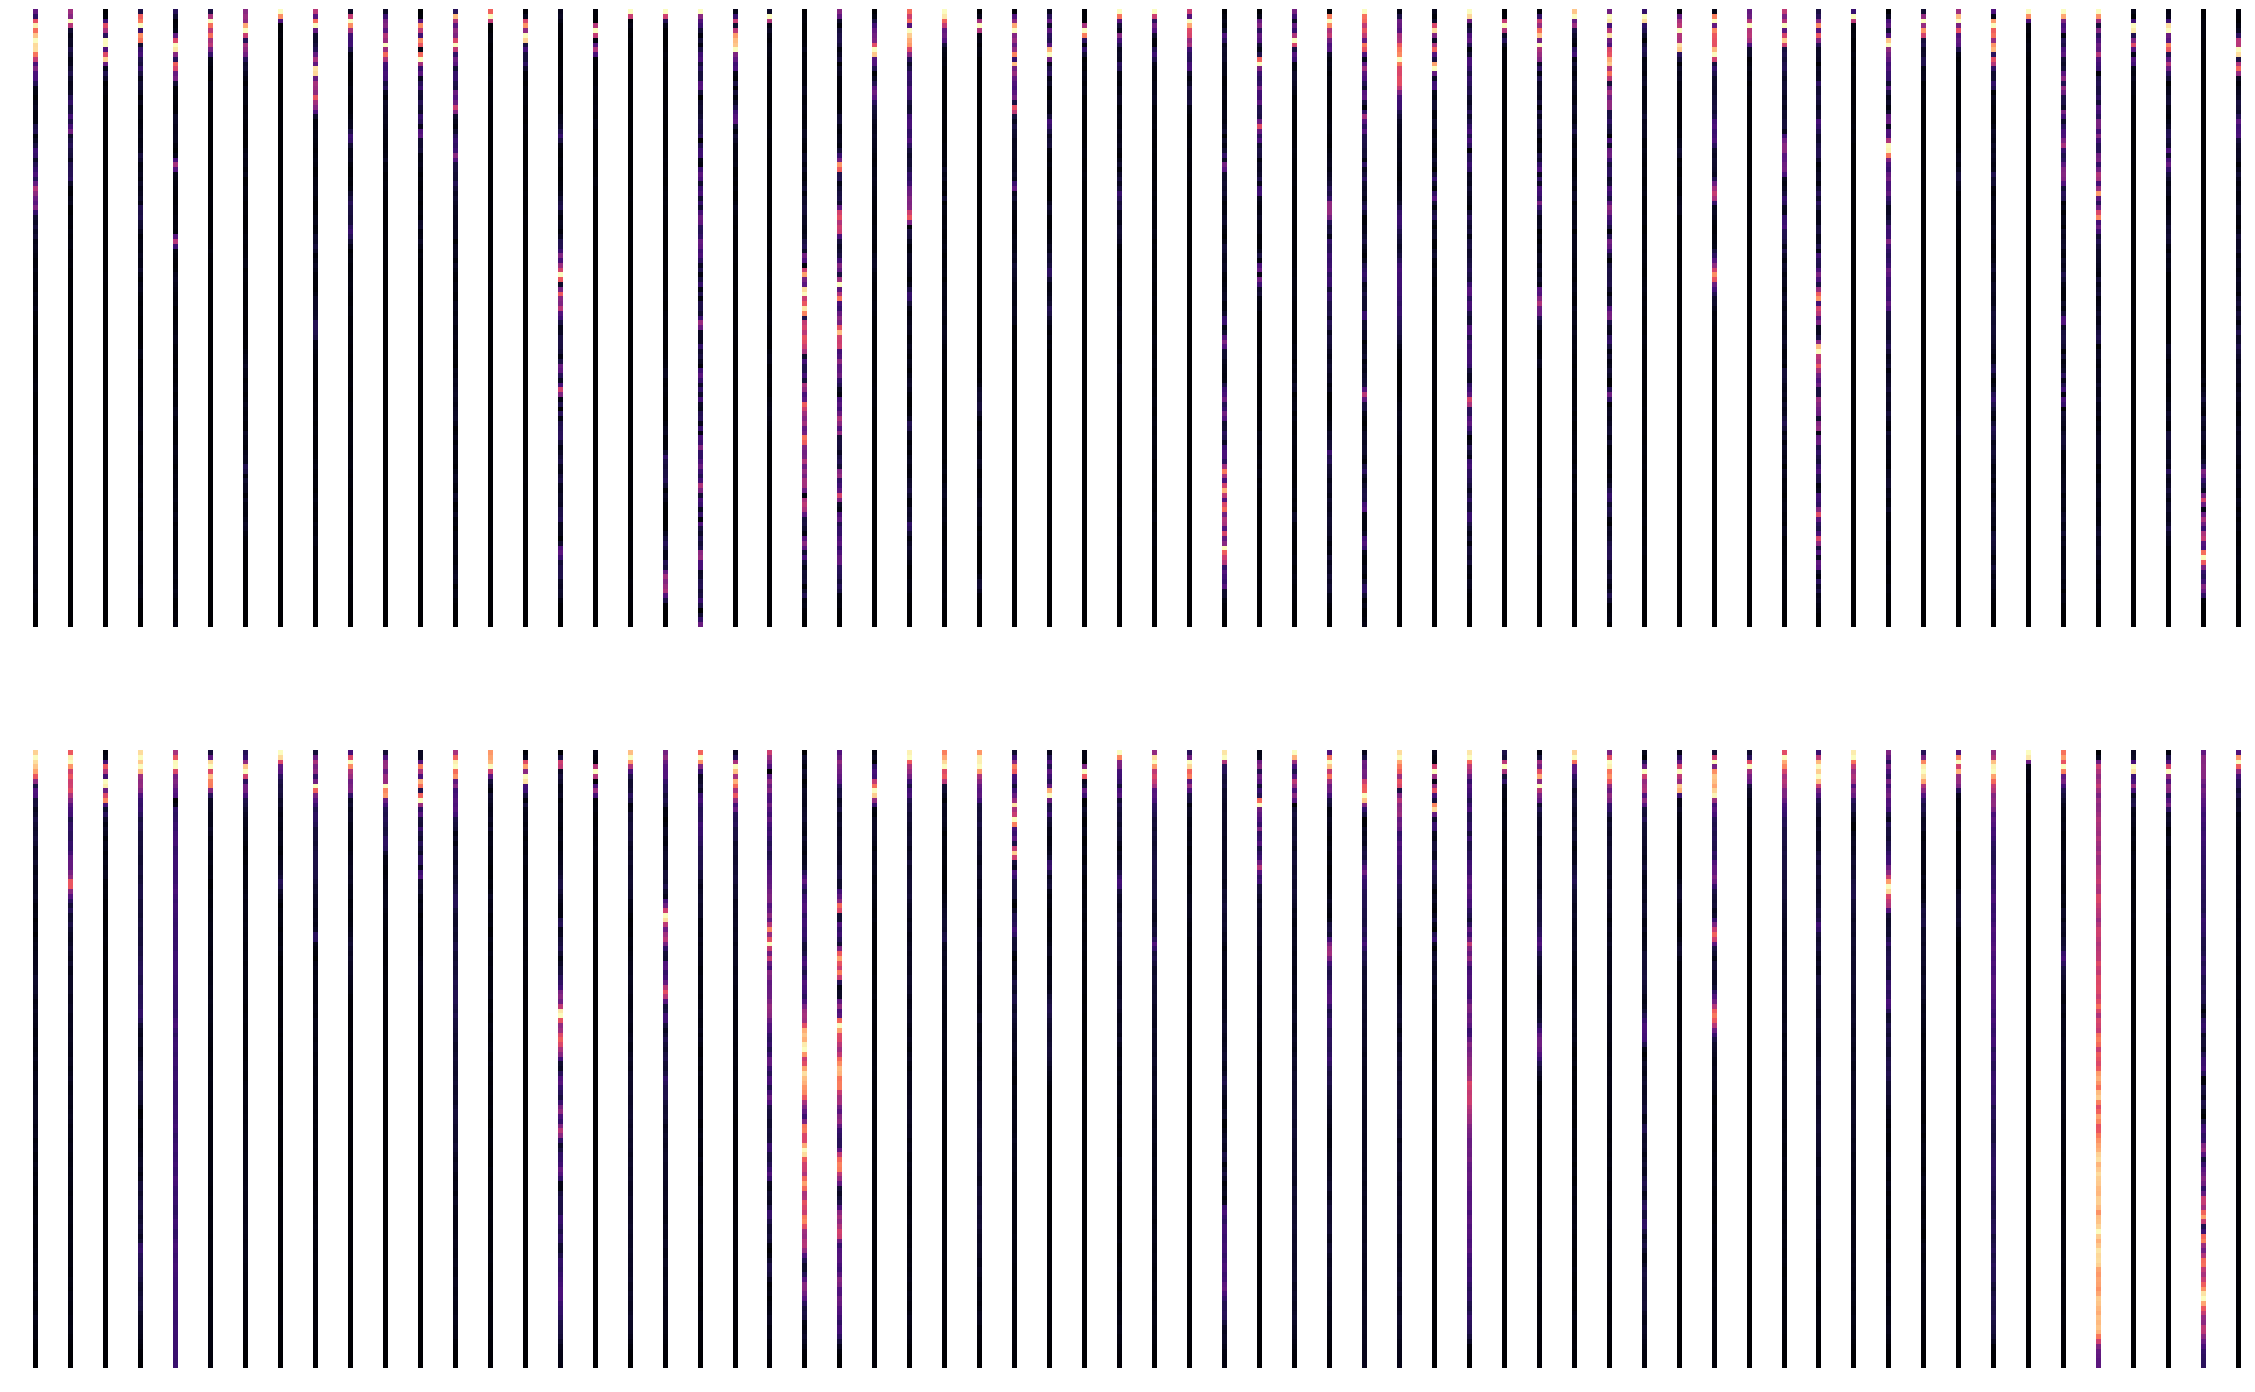

 Epoch 14 , loss 0.050153 , 450 sec (99%).
 Epoch: 14, Test set ELBO: 0.06345340609550476, time elapse for current epoch 507.76799750328064[s]



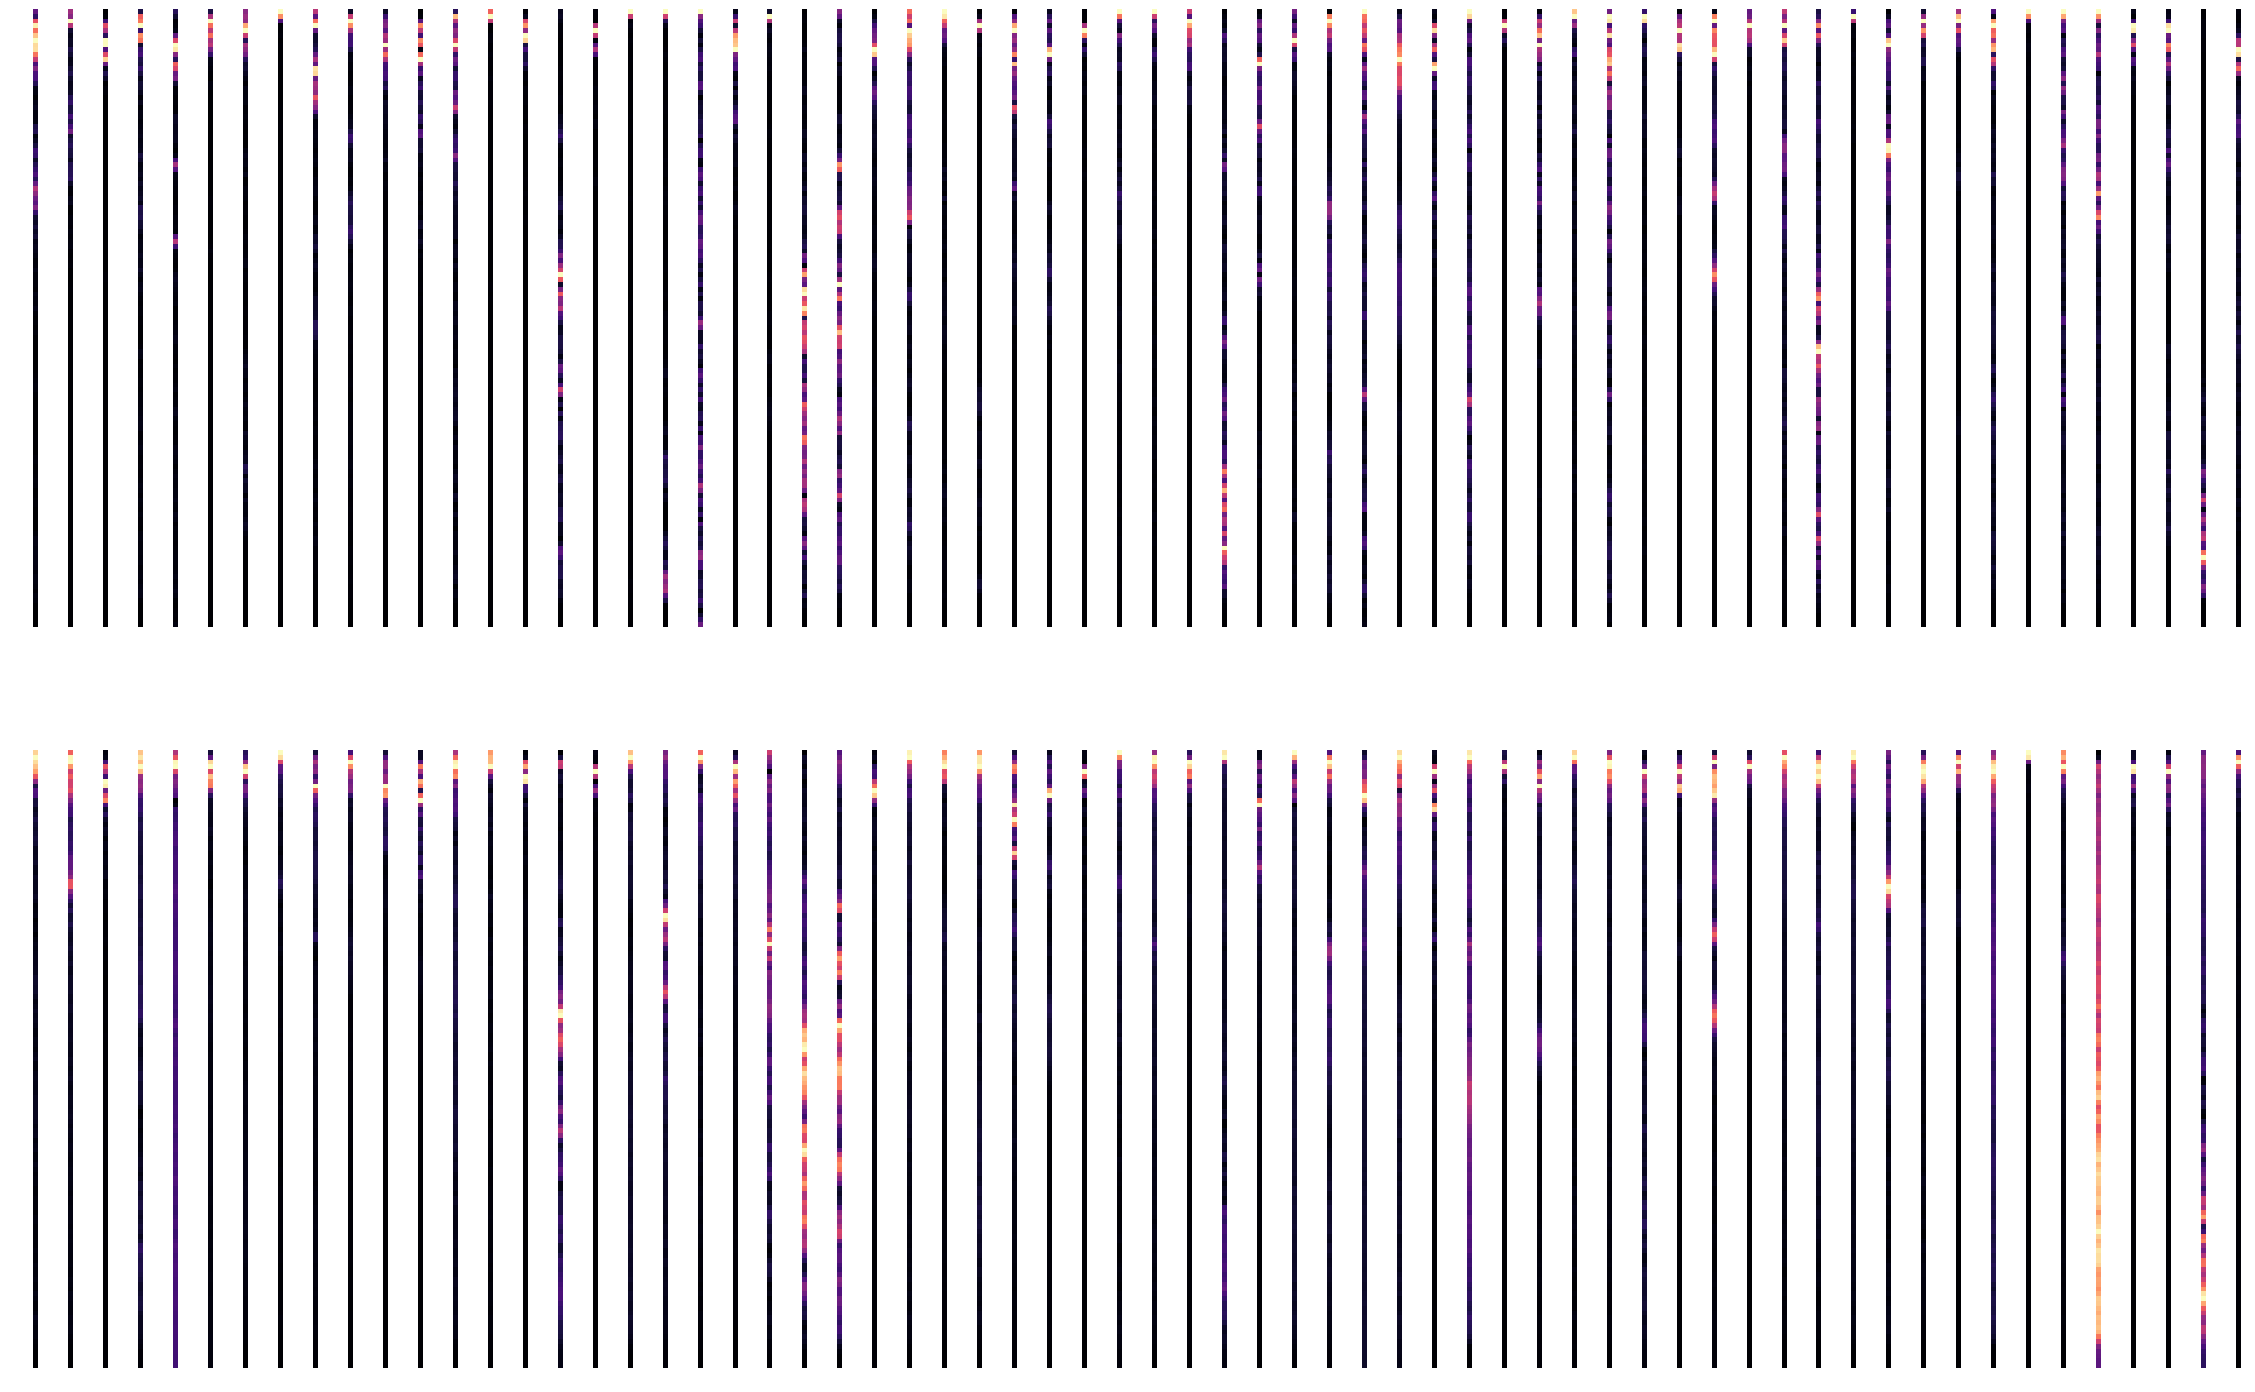

 Epoch 15 , loss 0.060420 , 451 sec (99%).
 Epoch: 15, Test set ELBO: 0.06264092773199081, time elapse for current epoch 508.8270003795624[s]



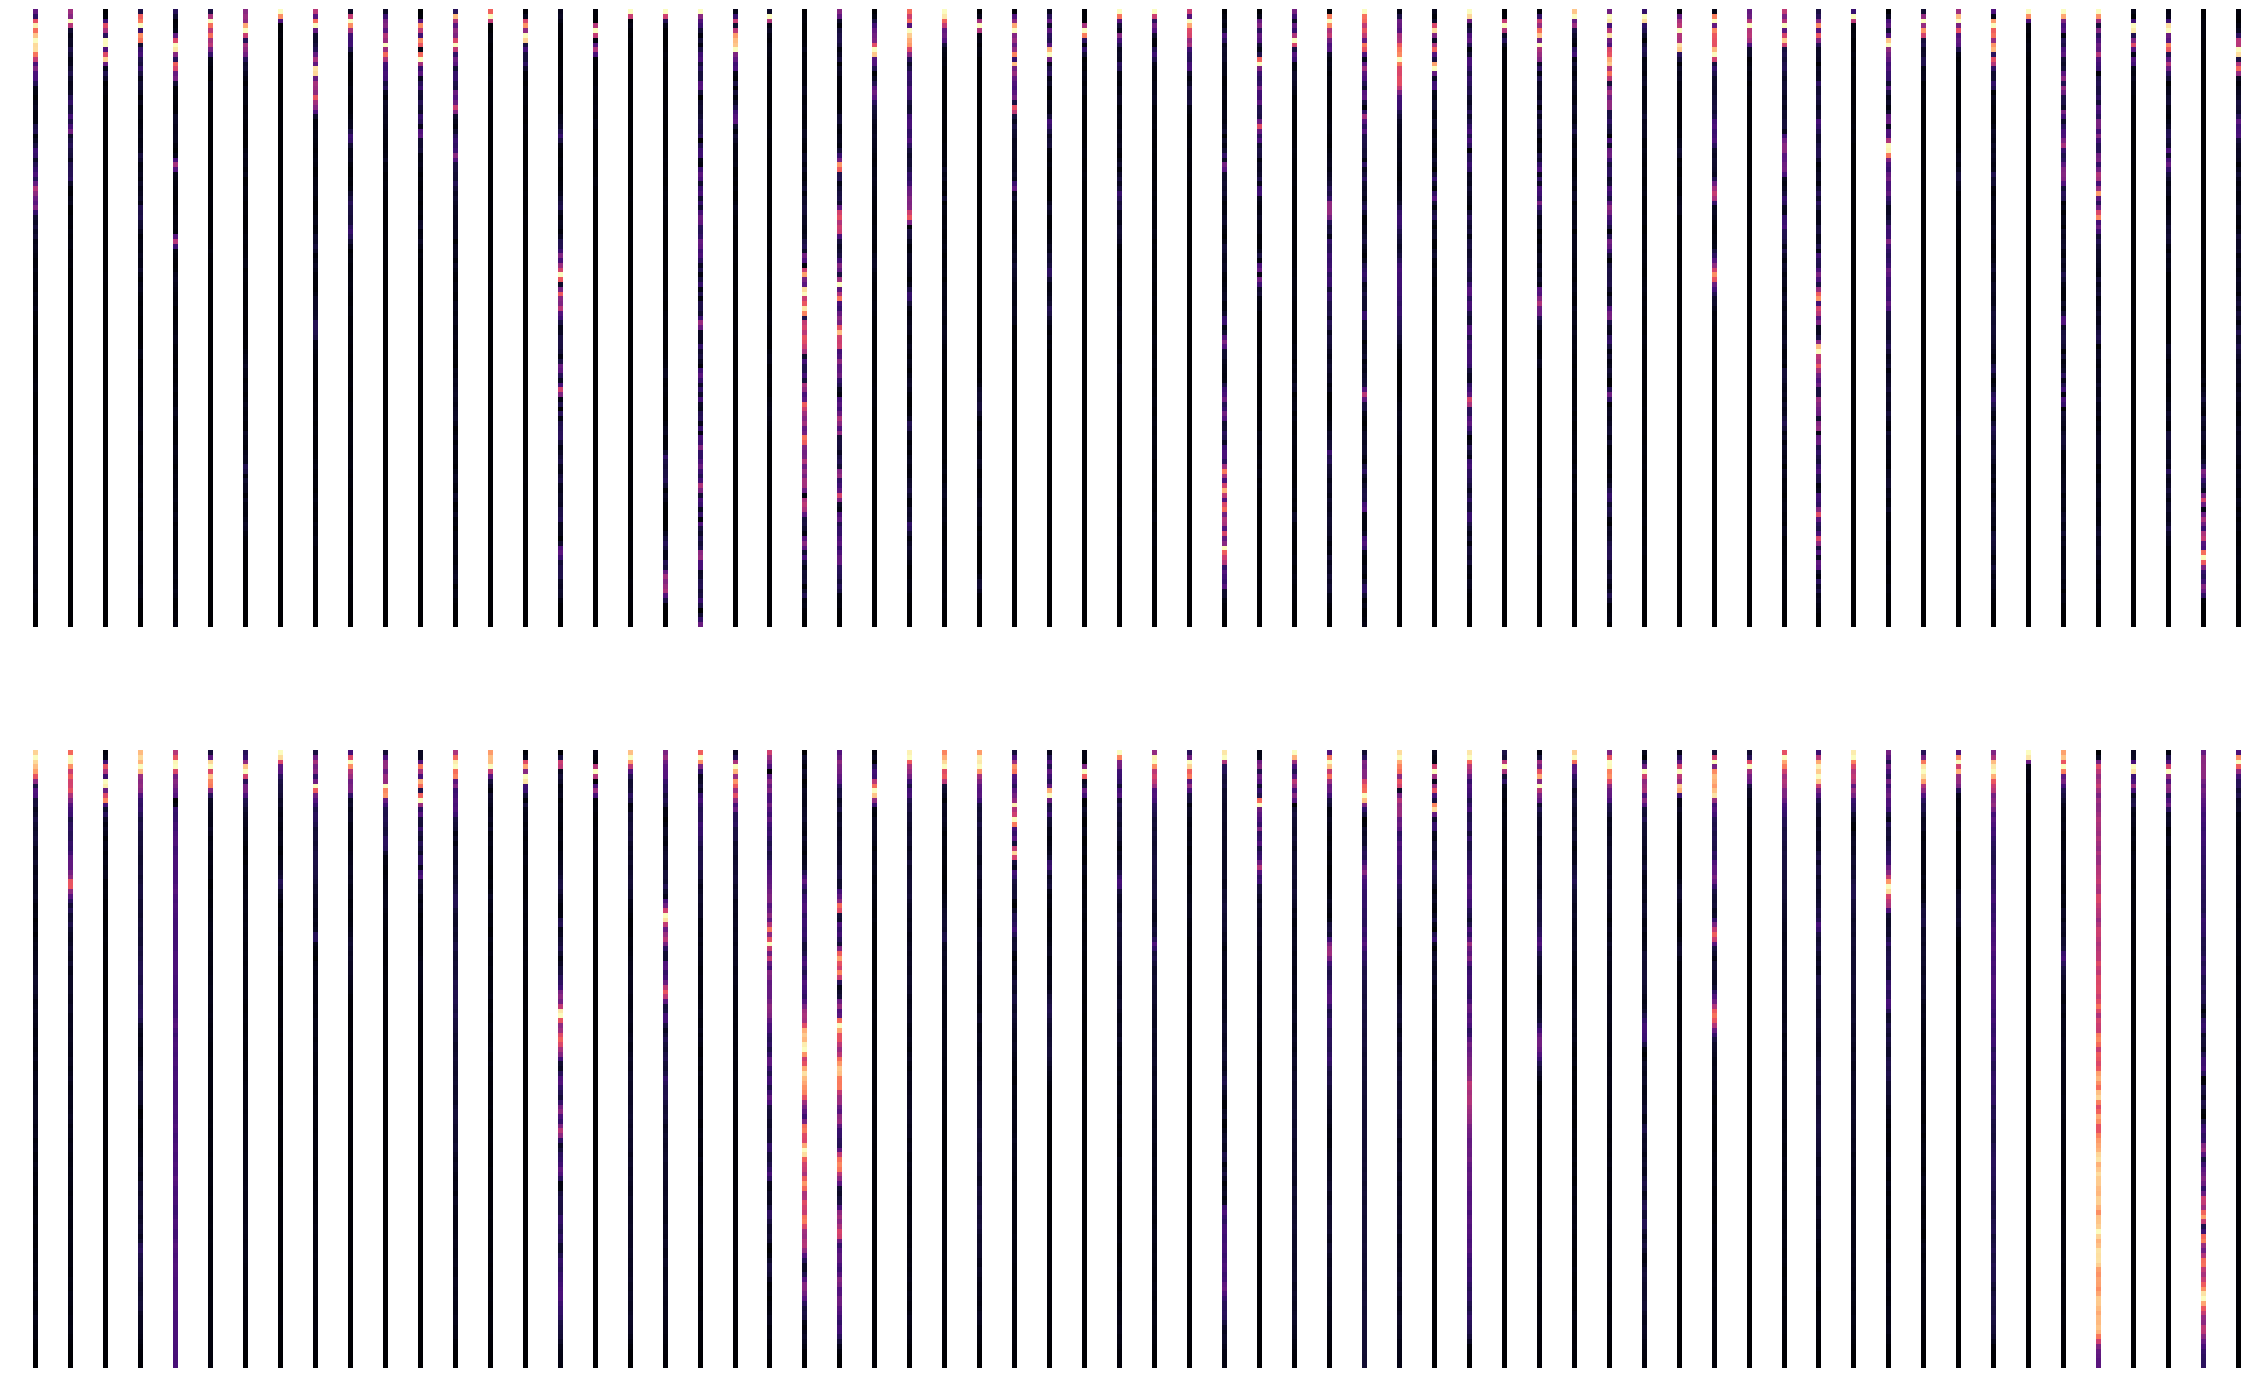

 Epoch 16 , loss 0.029029 , 447 sec (99%).
 Epoch: 16, Test set ELBO: 0.062049441039562225, time elapse for current epoch 503.87226724624634[s]



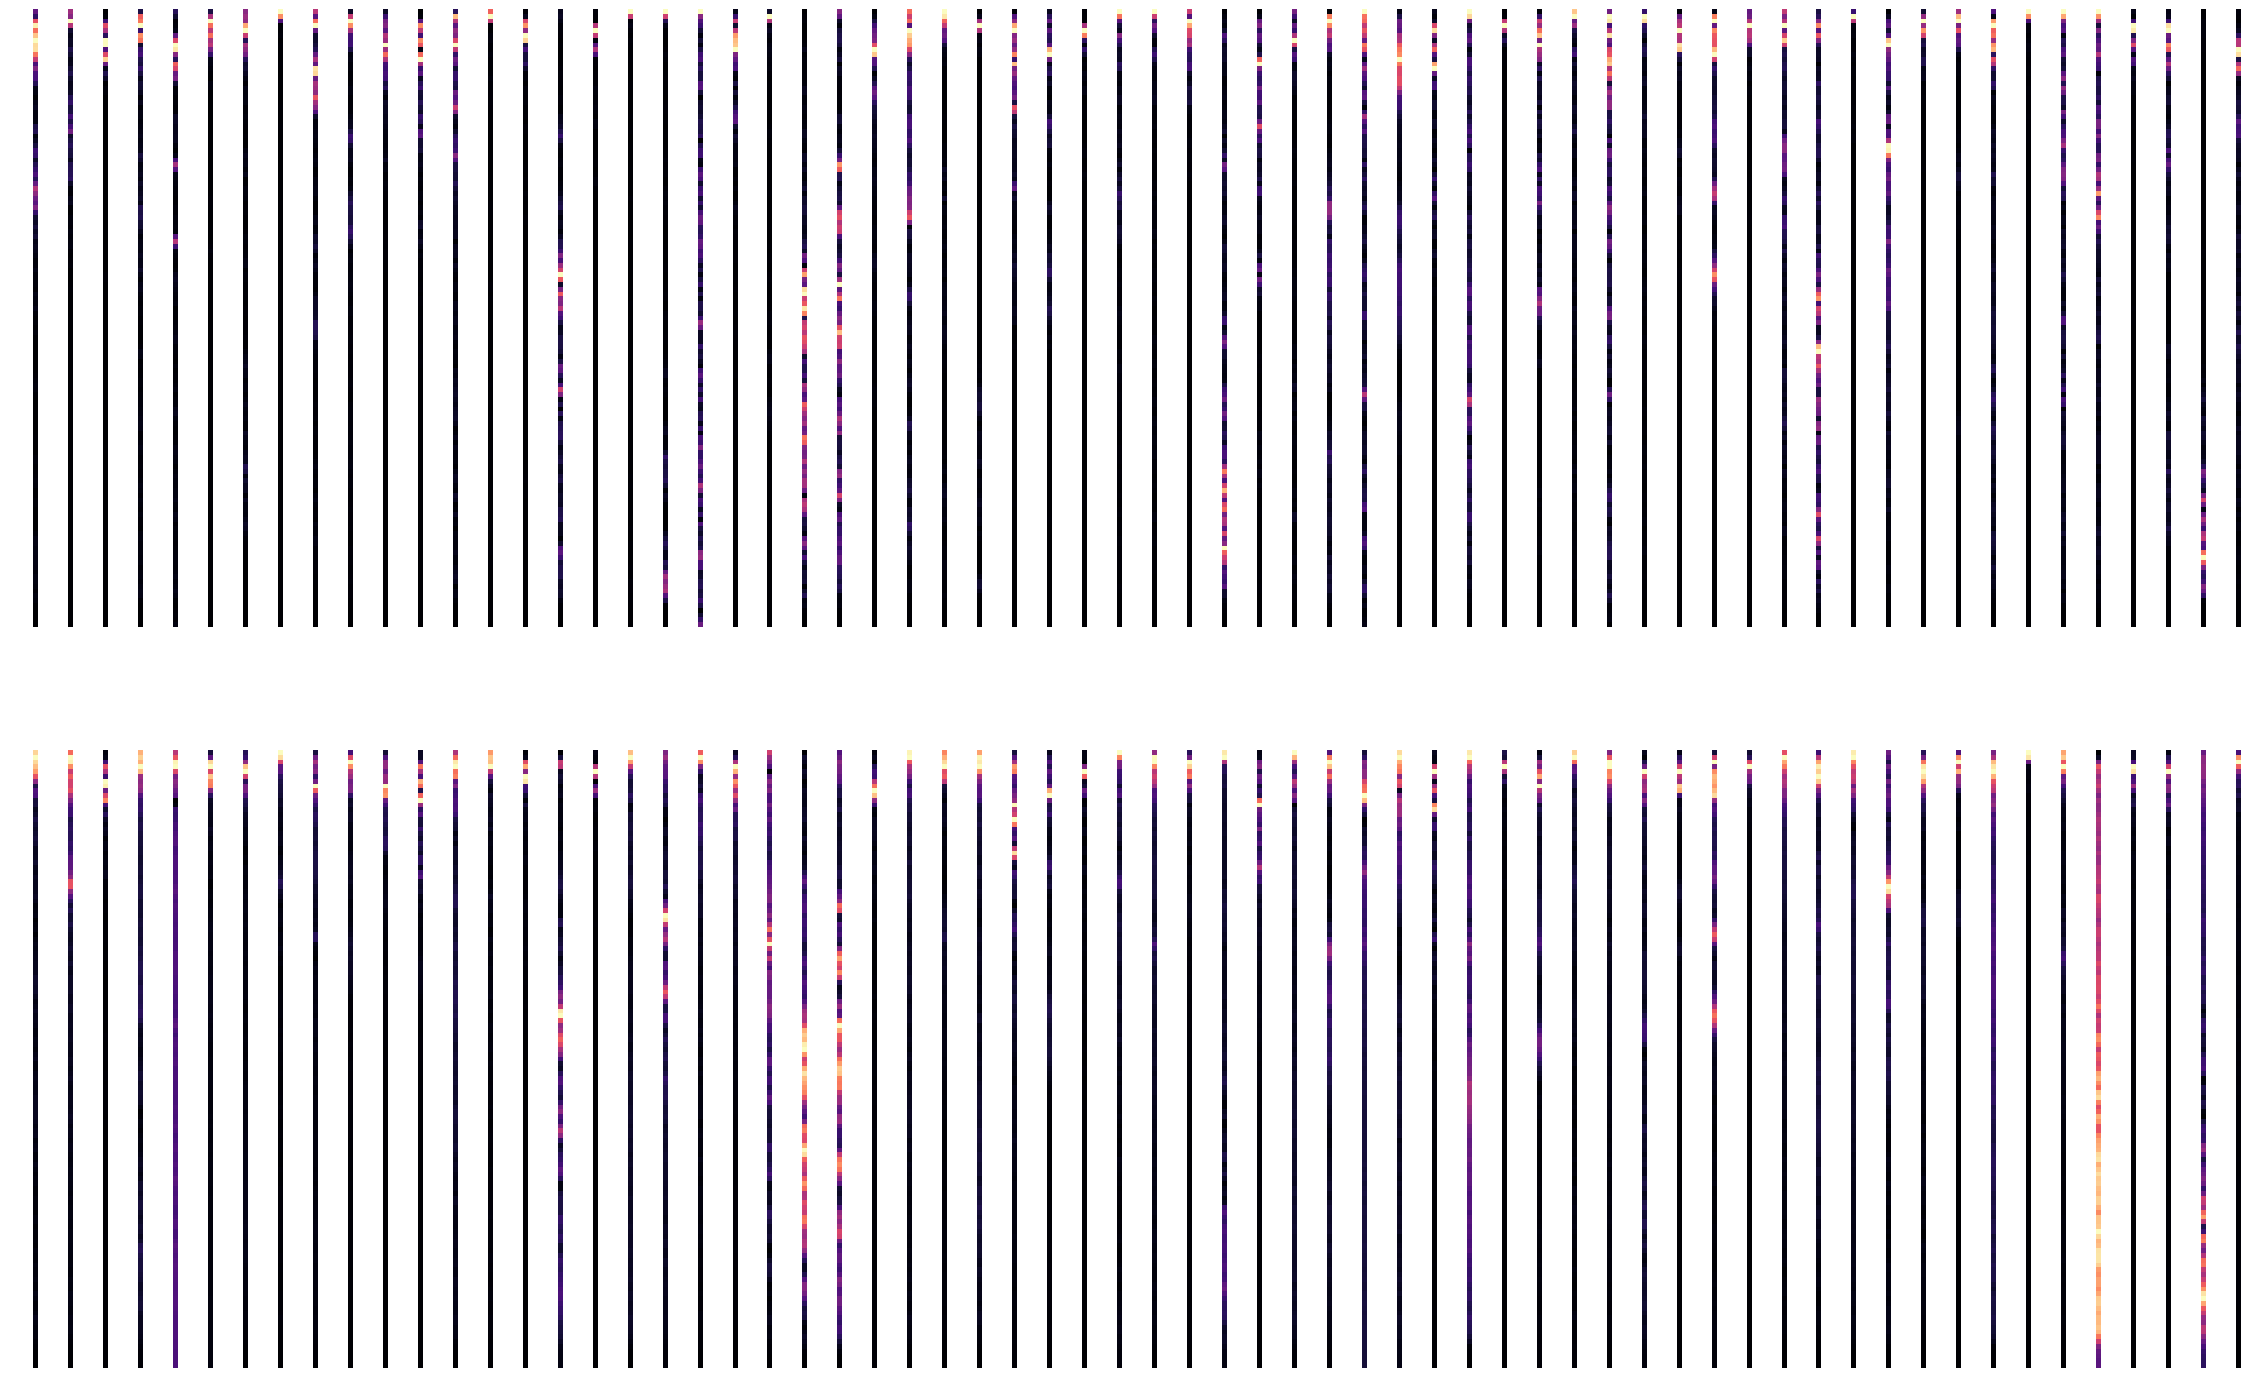

 Epoch 17 , loss 0.075051 , 451 sec (99%).
 Epoch: 17, Test set ELBO: 0.06160864233970642, time elapse for current epoch 509.20982098579407[s]



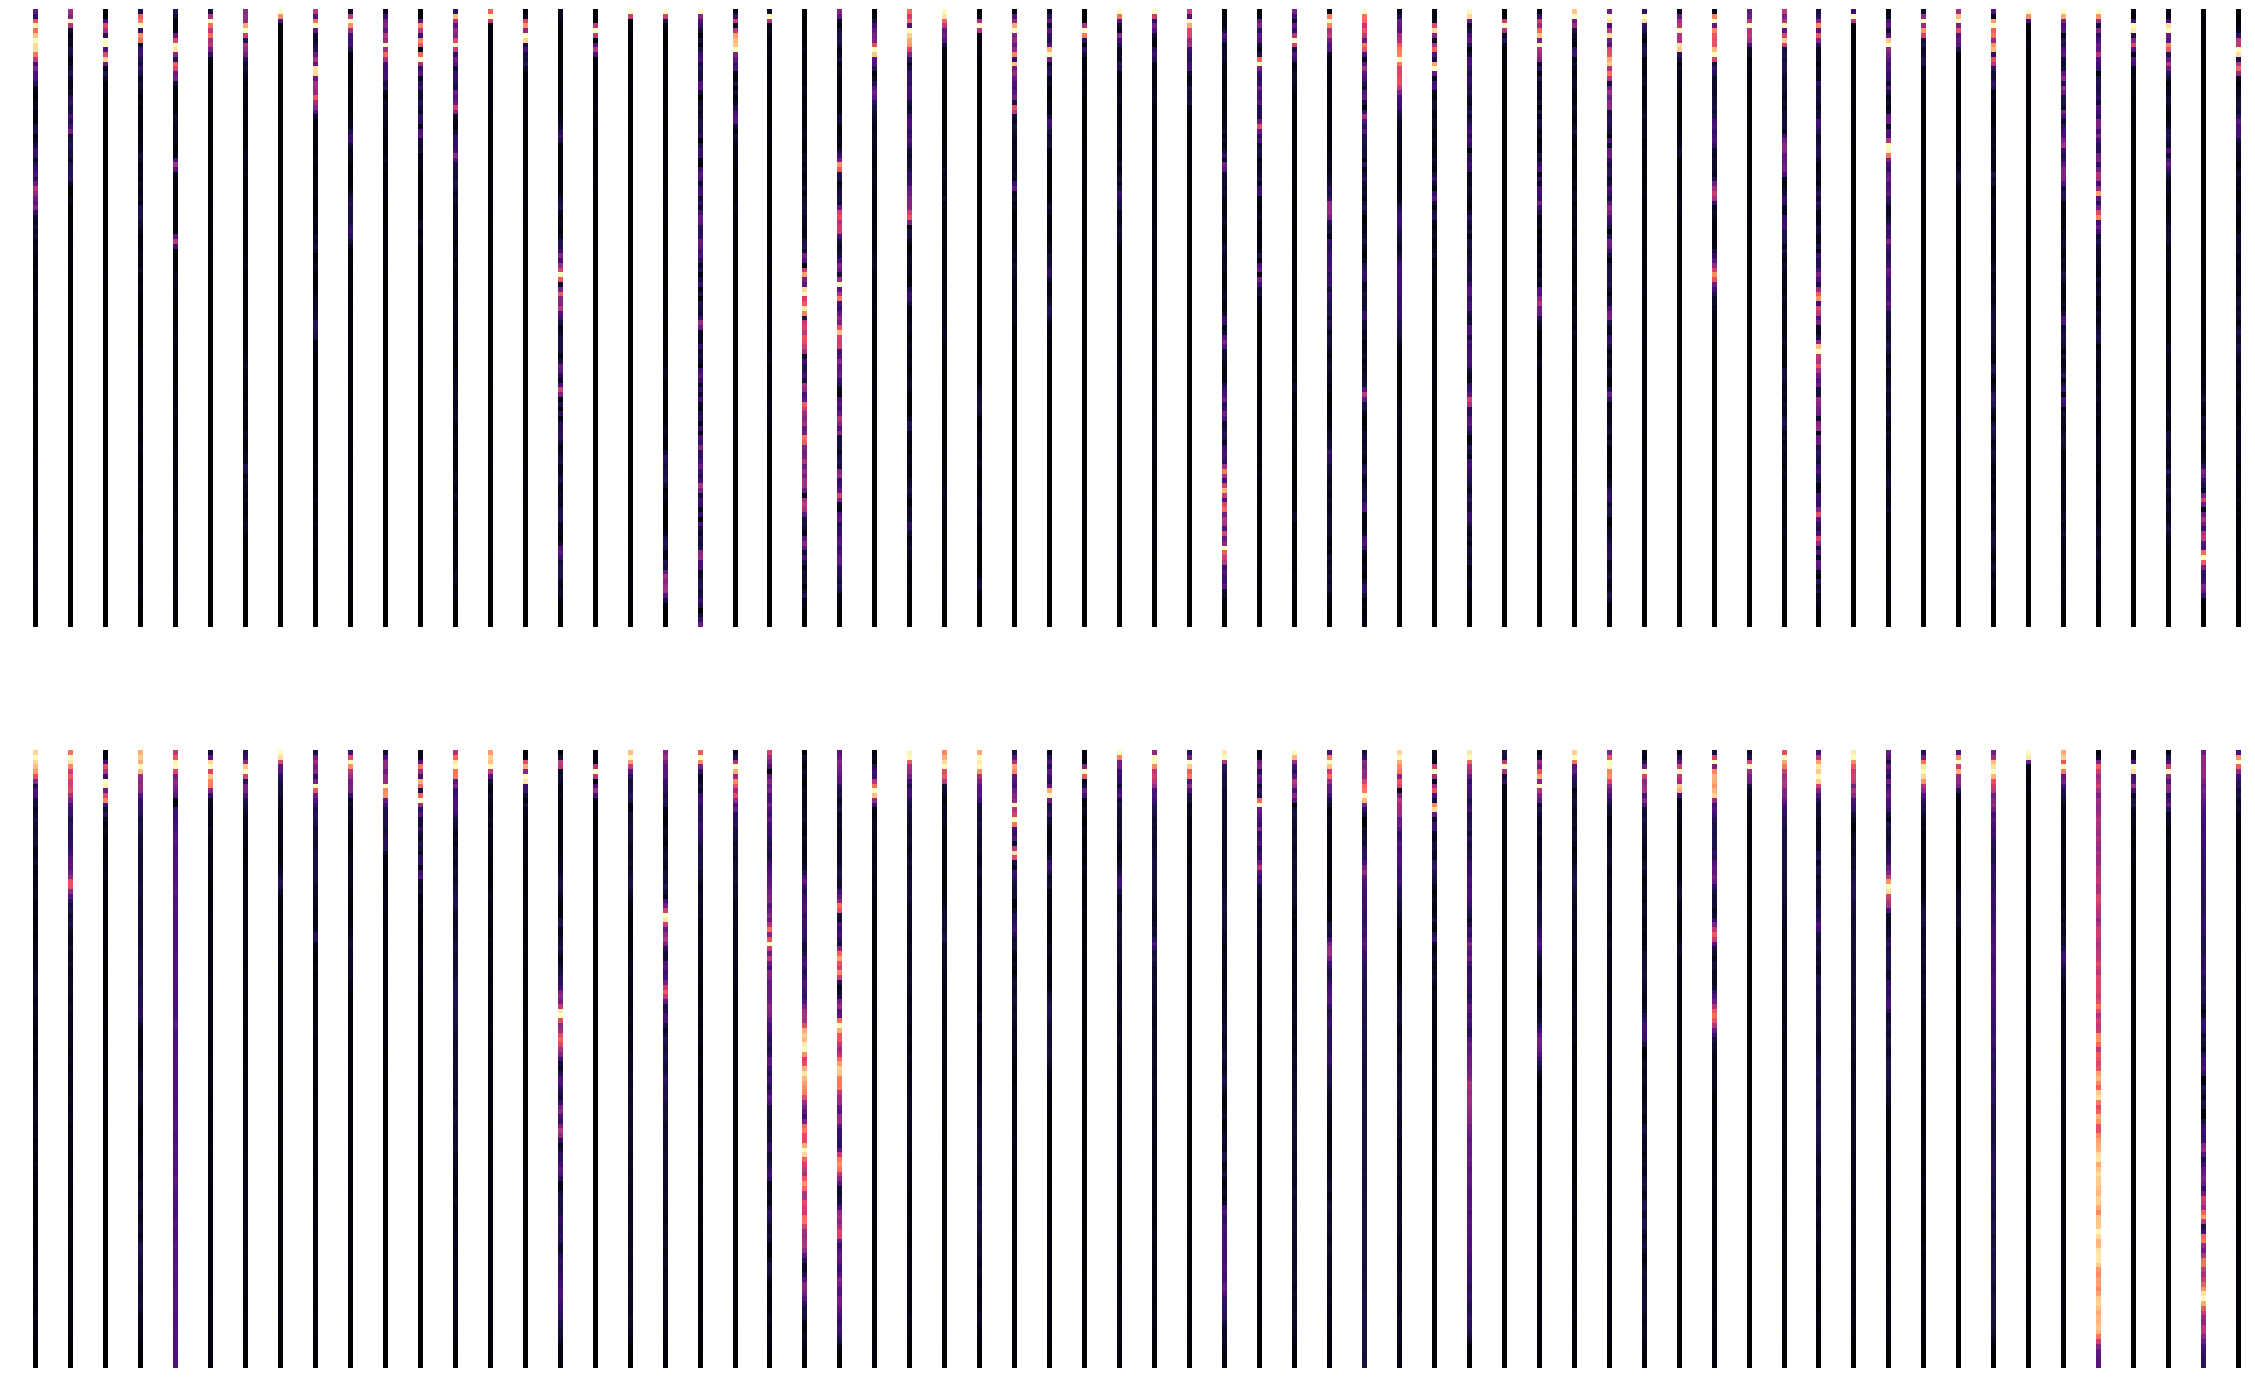

 Epoch 18 , loss 0.096573 , 447 sec (99%).
 Epoch: 18, Test set ELBO: 0.06128012388944626, time elapse for current epoch 504.96031641960144[s]



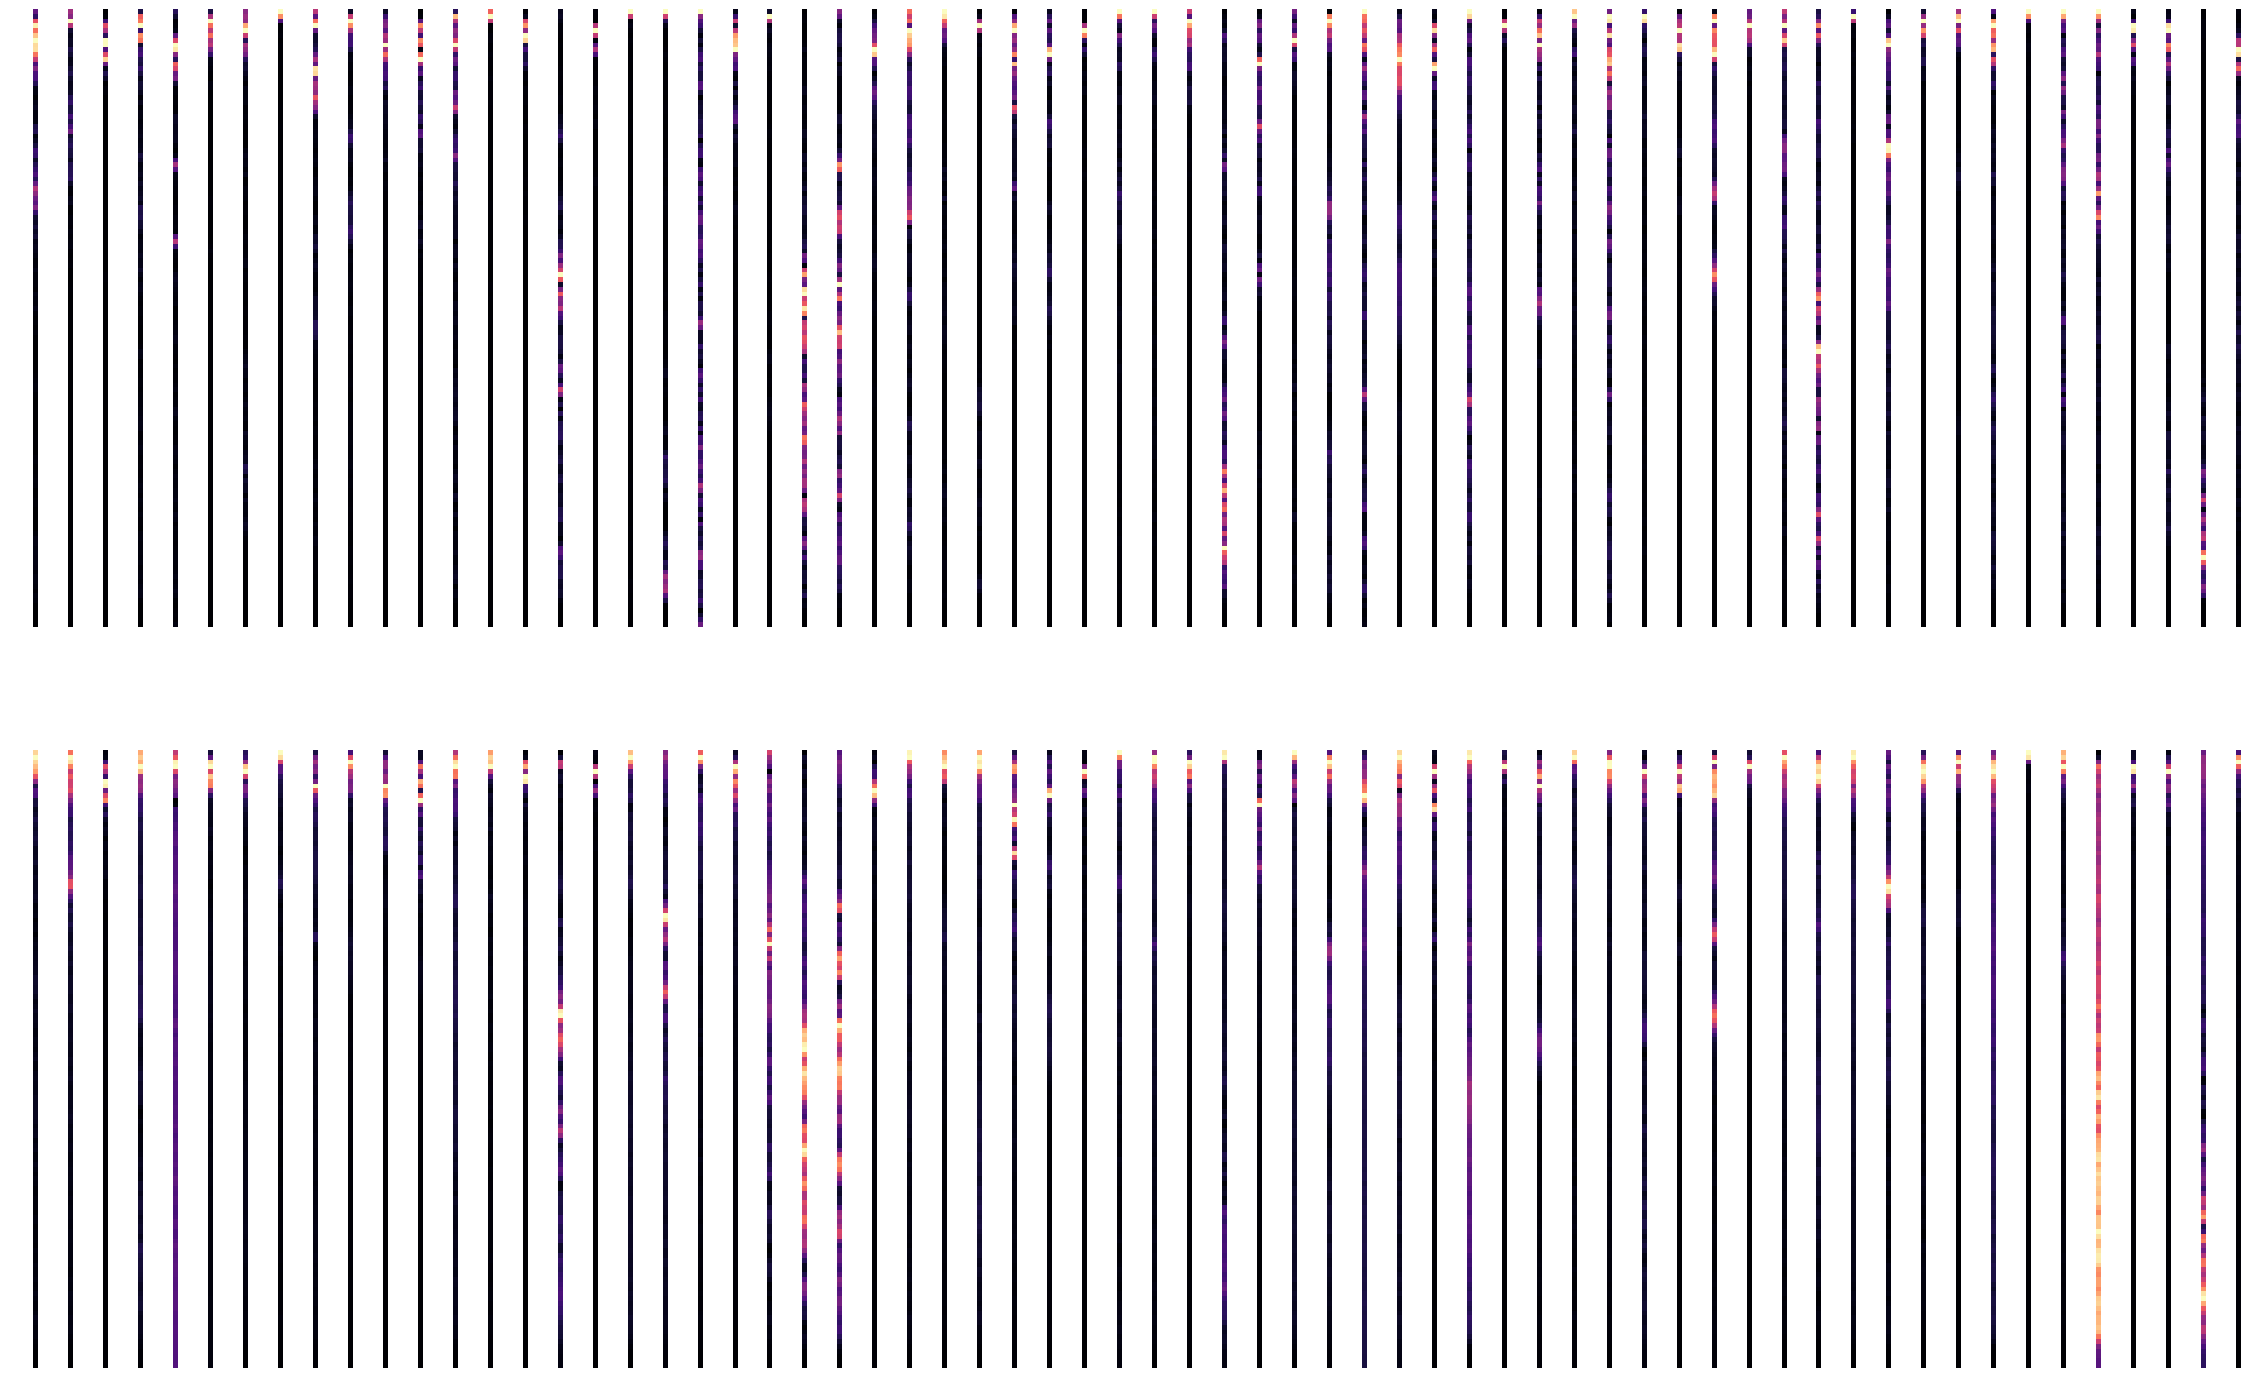

 Epoch 19 , loss 0.042014 , 450 sec (99%).
 Epoch: 19, Test set ELBO: 0.060964565724134445, time elapse for current epoch 508.2004578113556[s]



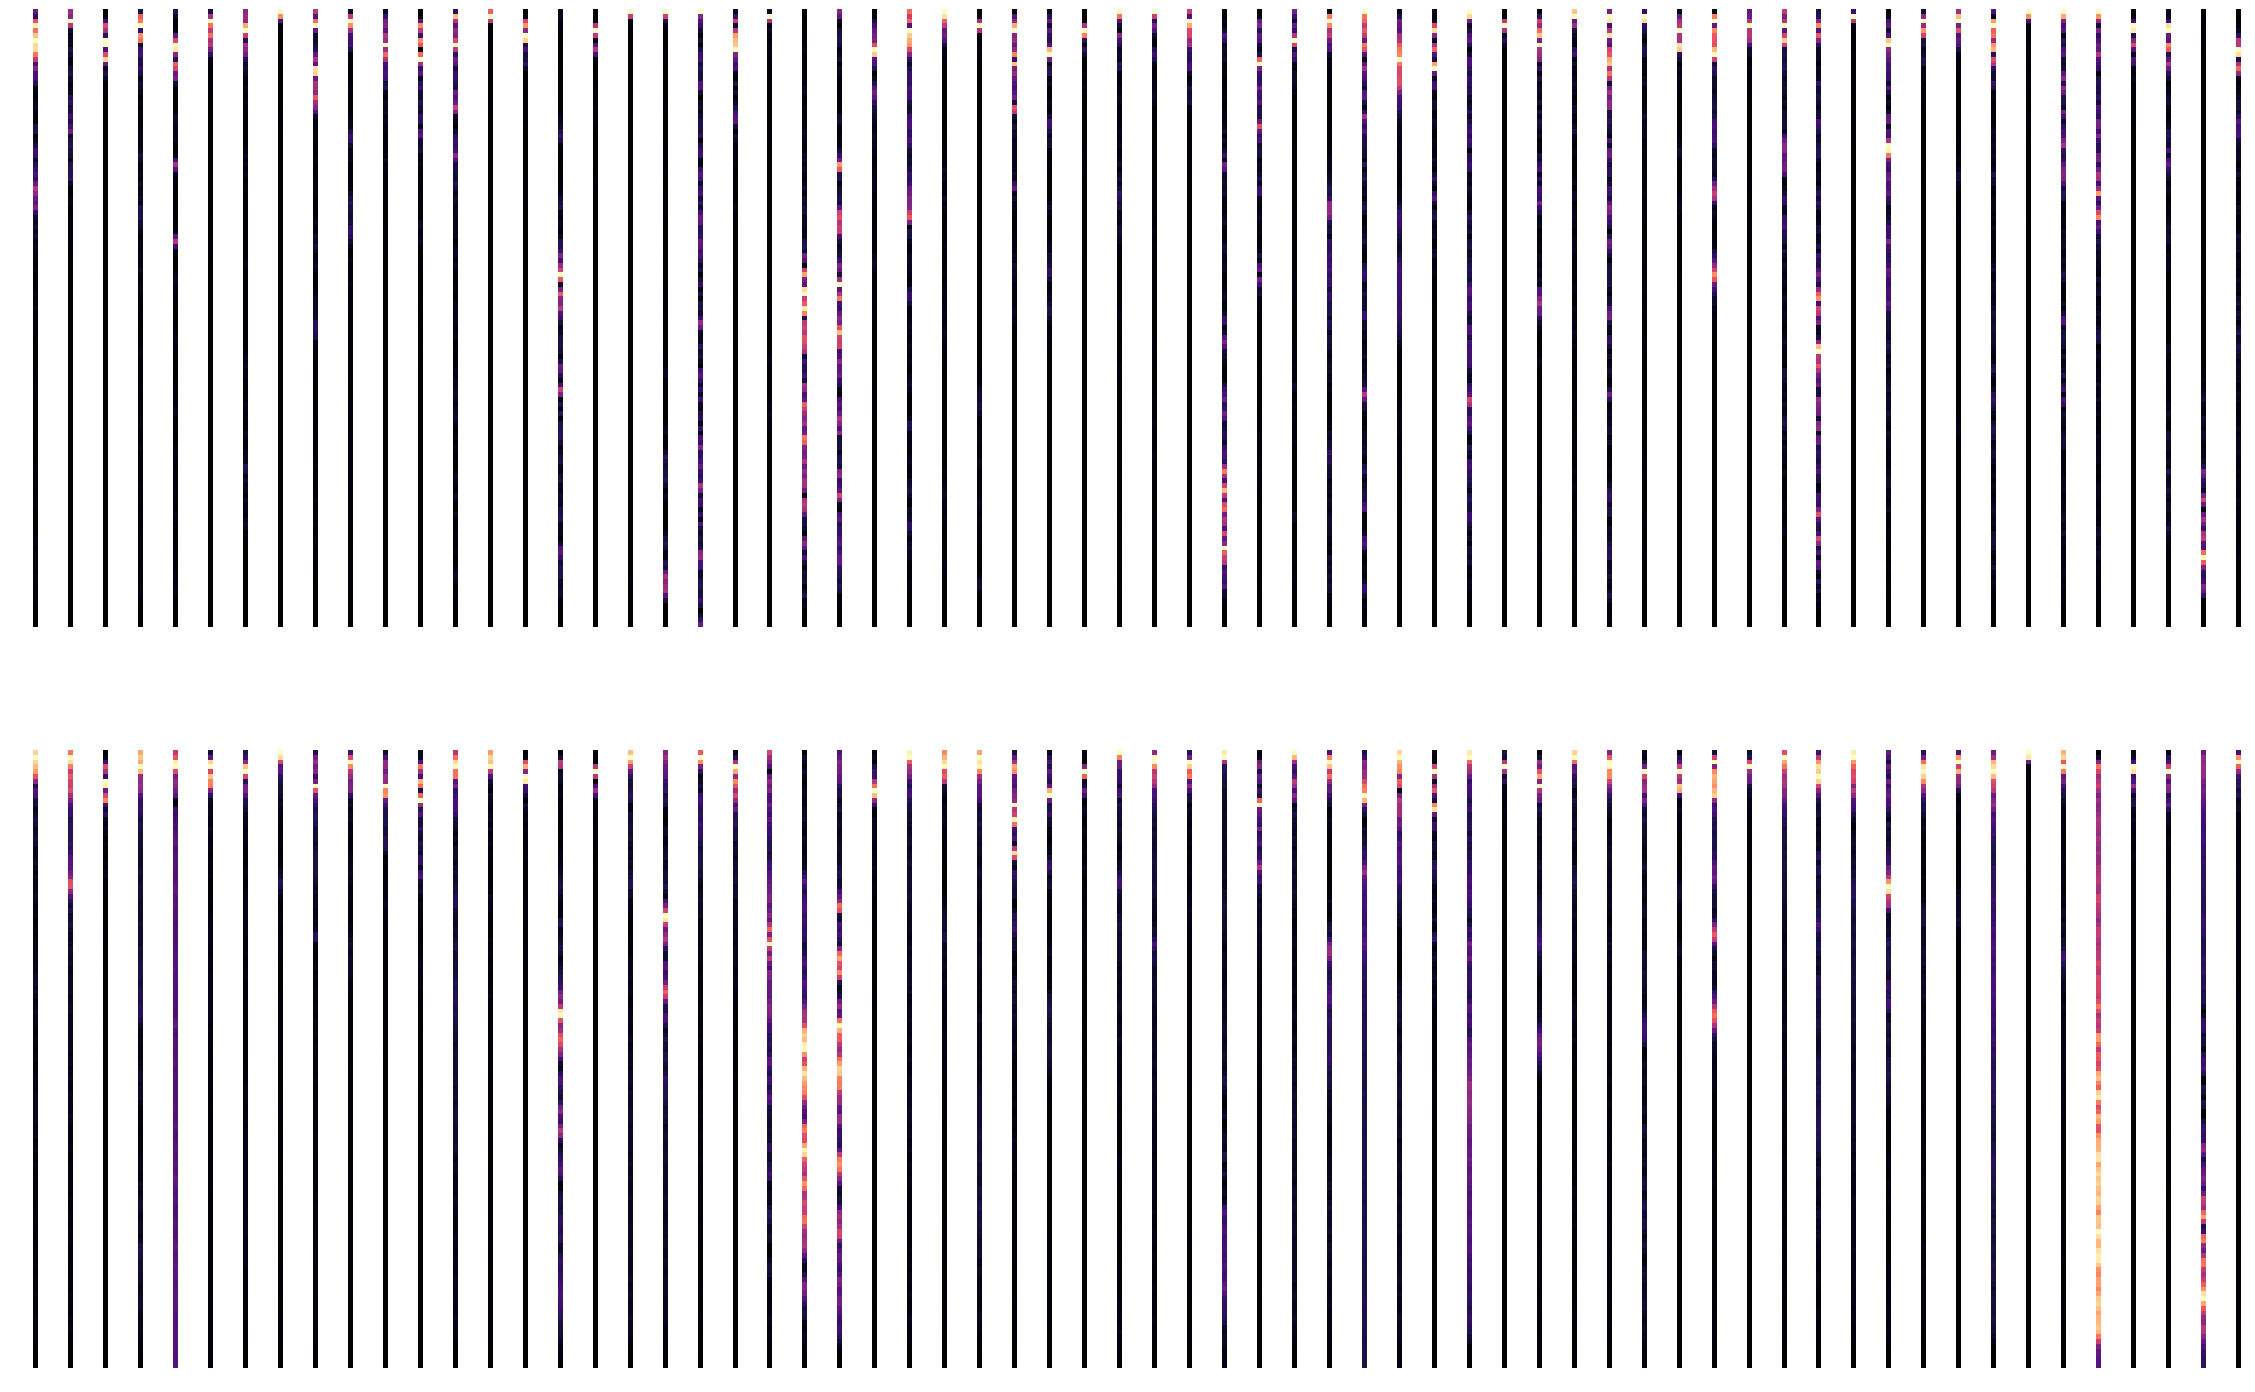

 Epoch 20 , loss 0.056504 , 447 sec (99%).
 Epoch: 20, Test set ELBO: 0.060678888112306595, time elapse for current epoch 504.9055554866791[s]



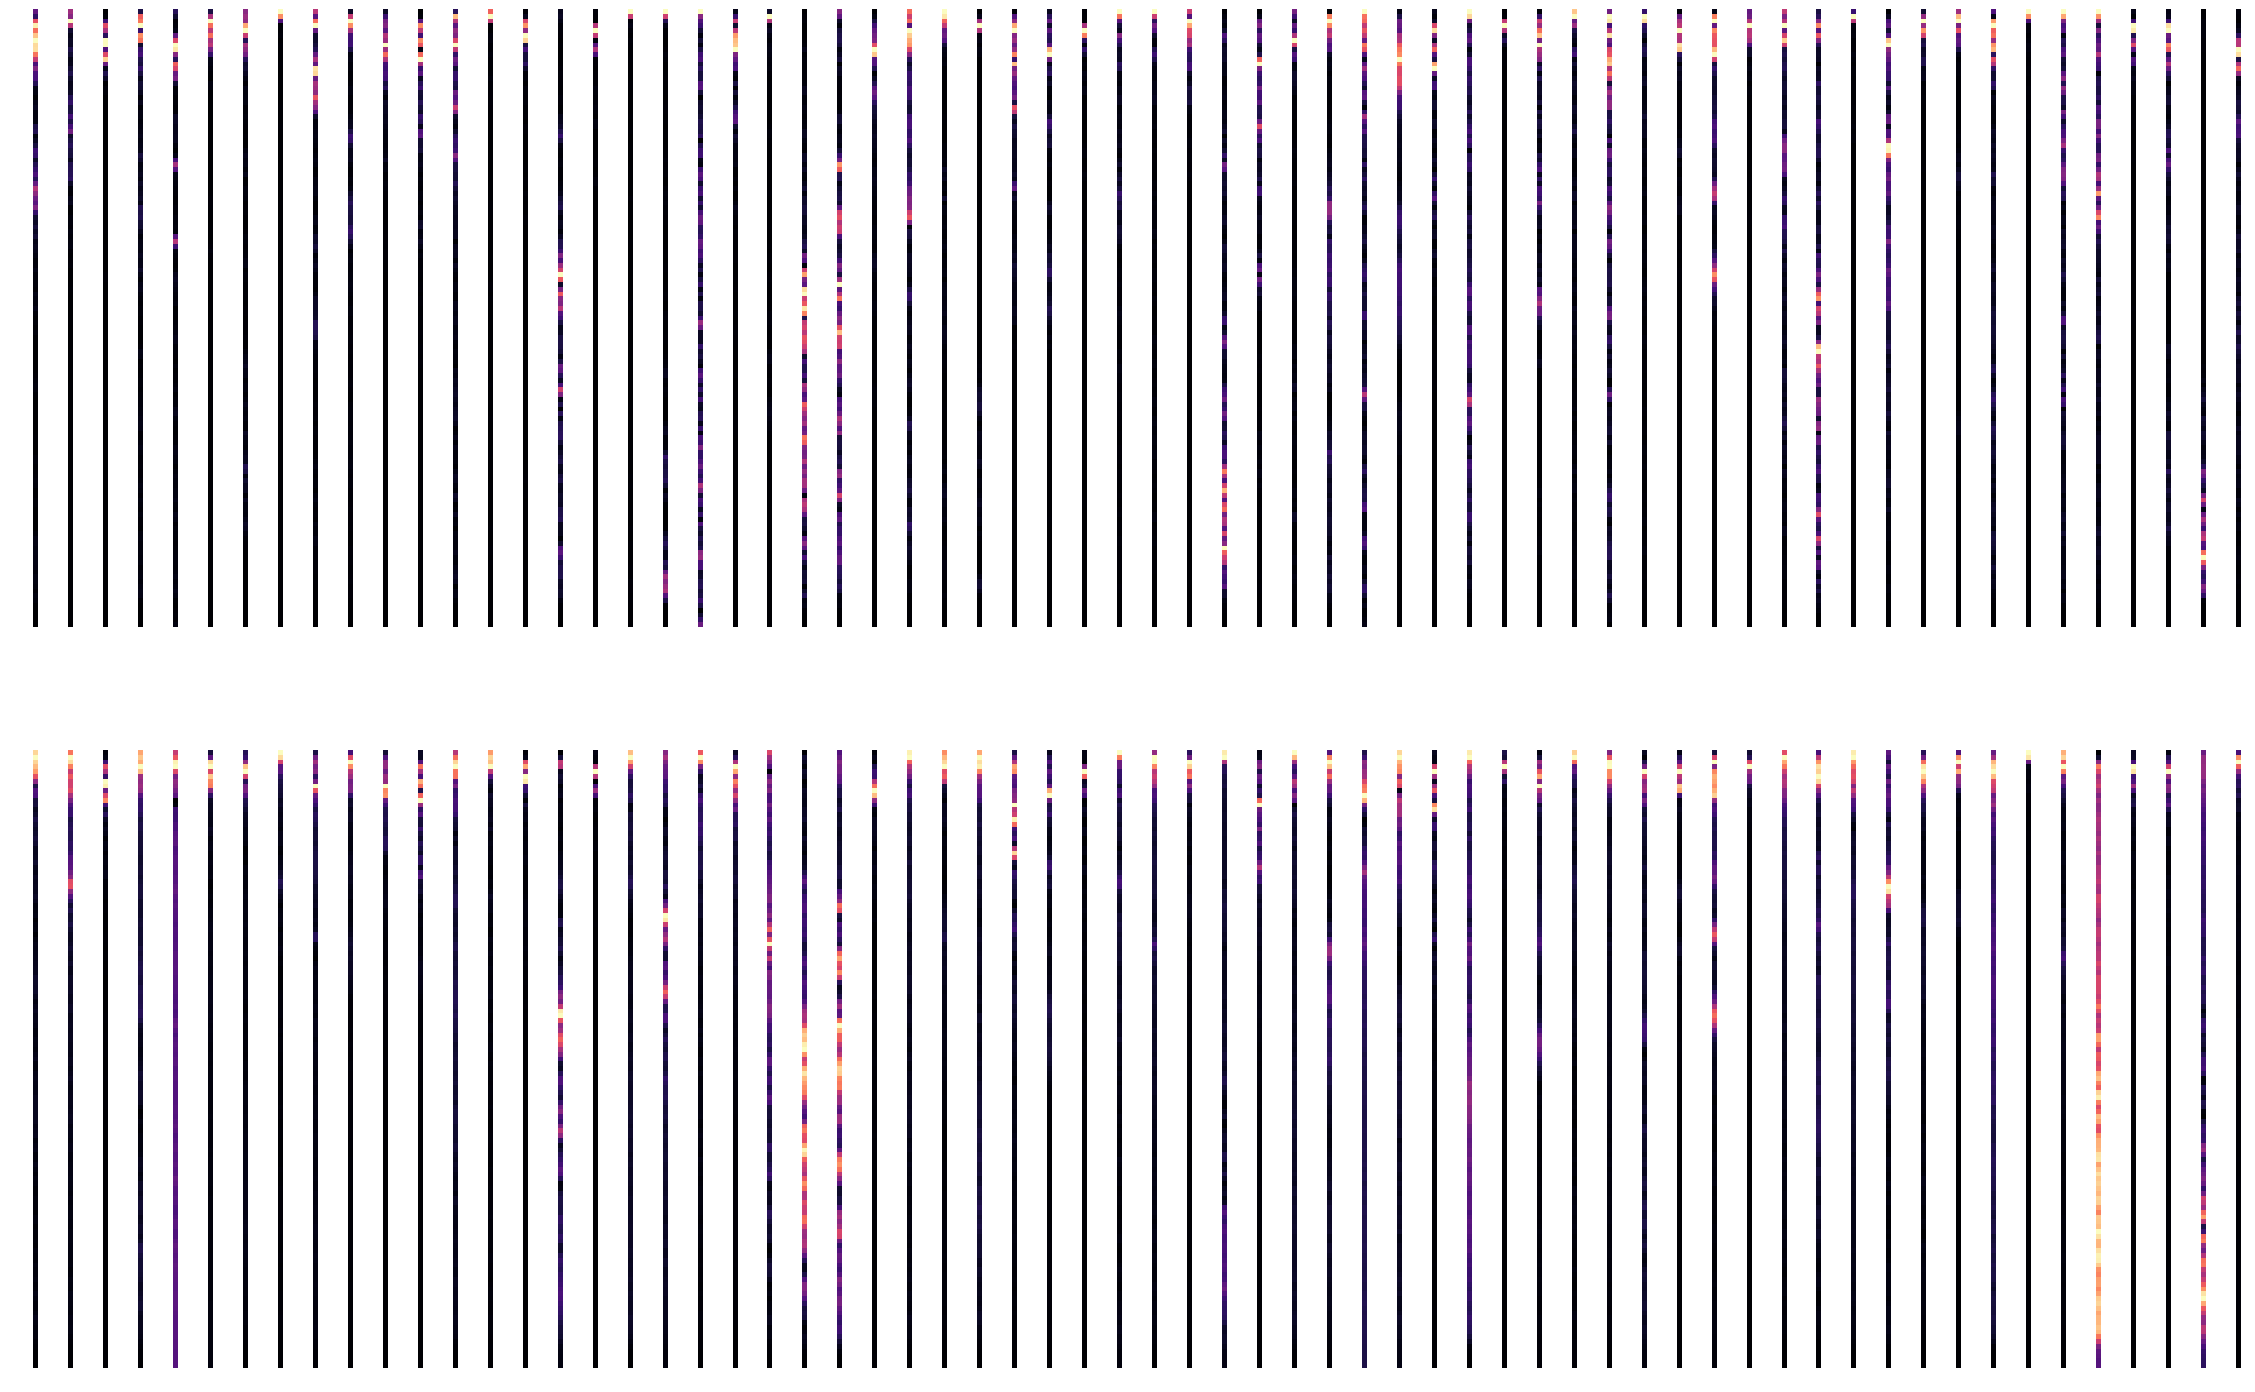

 Epoch 21 , loss 0.030129 , 449 sec (99%).
 Epoch: 21, Test set ELBO: 0.06050831824541092, time elapse for current epoch 507.8137266635895[s]



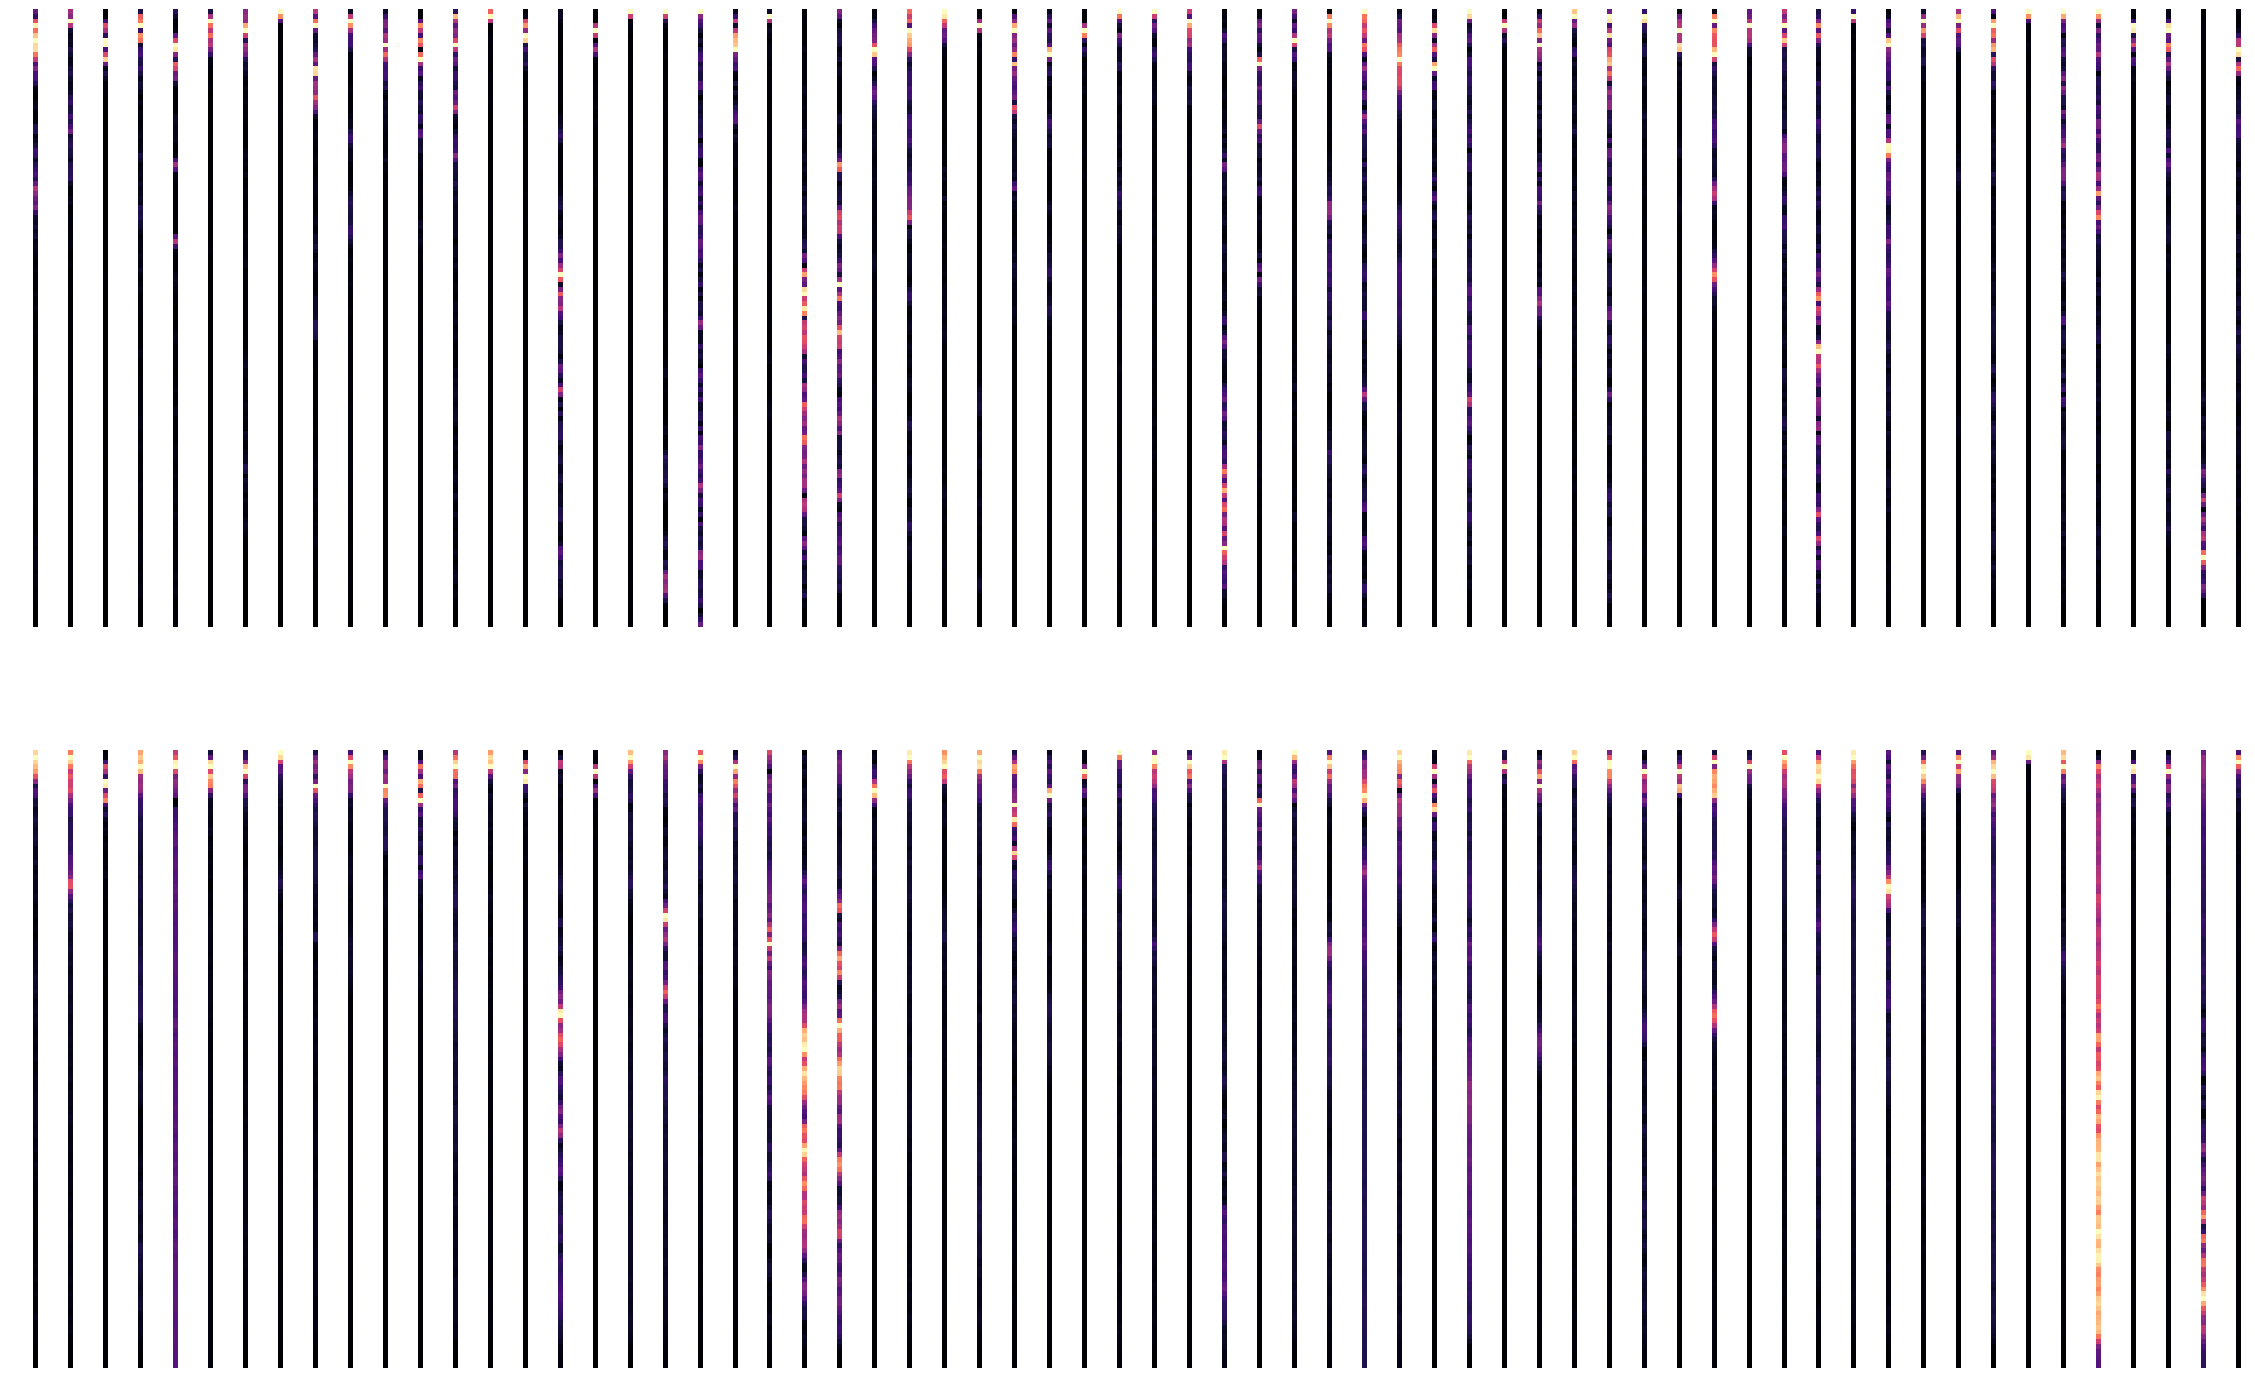

 Epoch 22 , loss 0.056131 , 451 sec (99%).
 Epoch: 22, Test set ELBO: 0.0602860301733017, time elapse for current epoch 509.11079716682434[s]



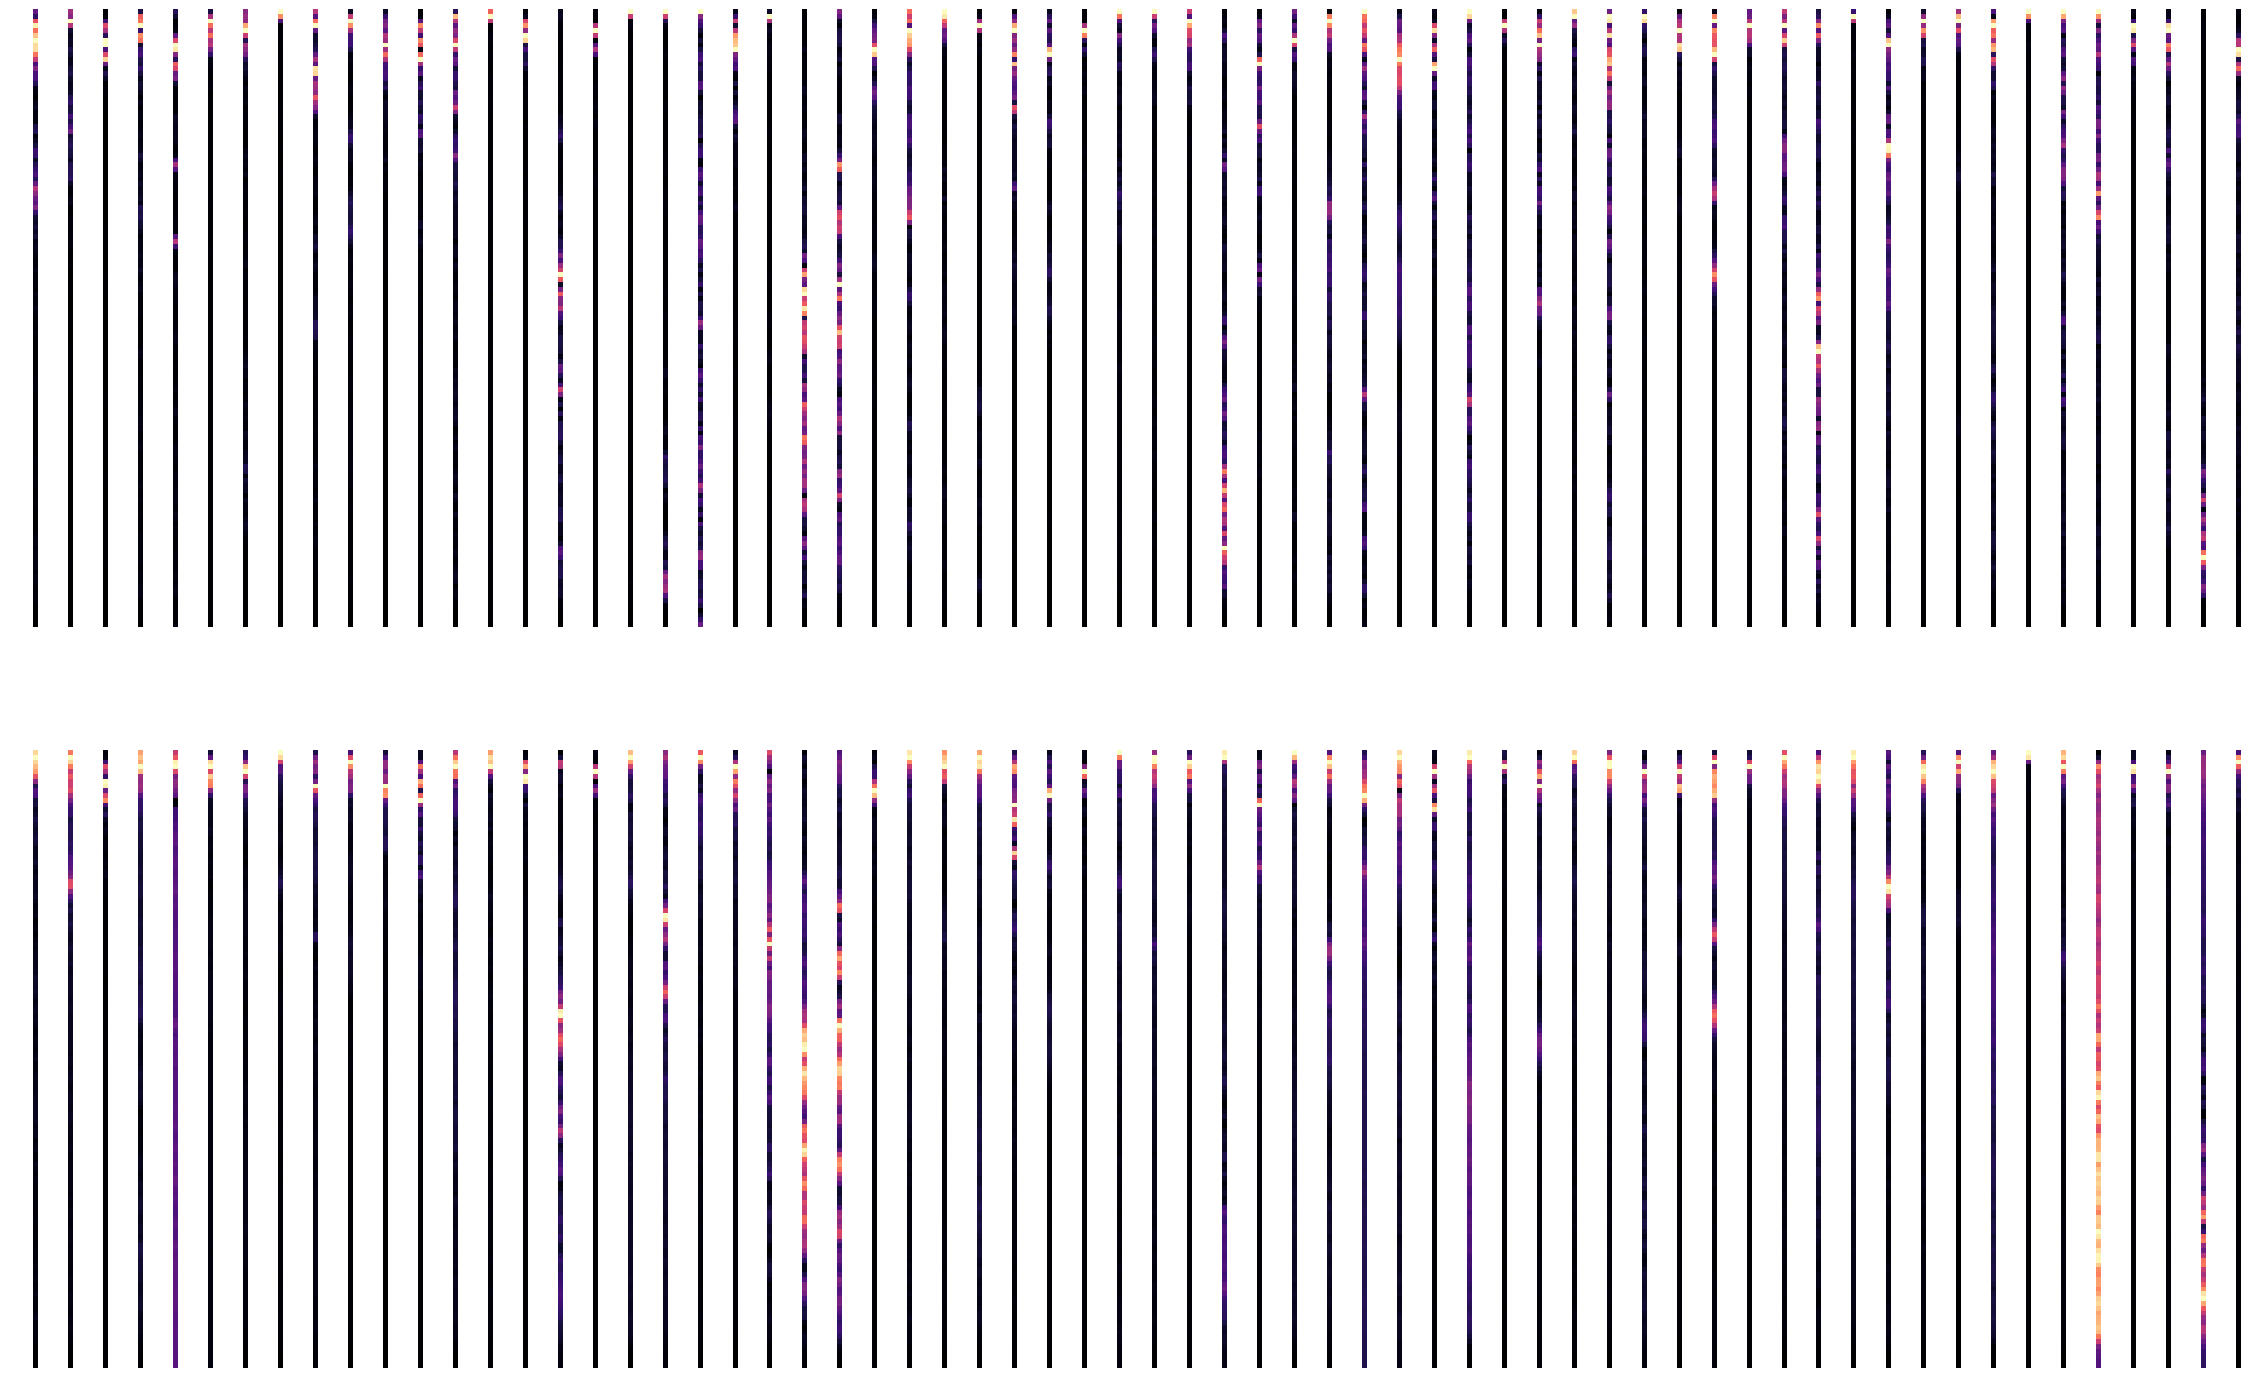

 Epoch 23 , loss 0.050911 , 447 sec (99%).
 Epoch: 23, Test set ELBO: 0.060099005699157715, time elapse for current epoch 505.03244042396545[s]



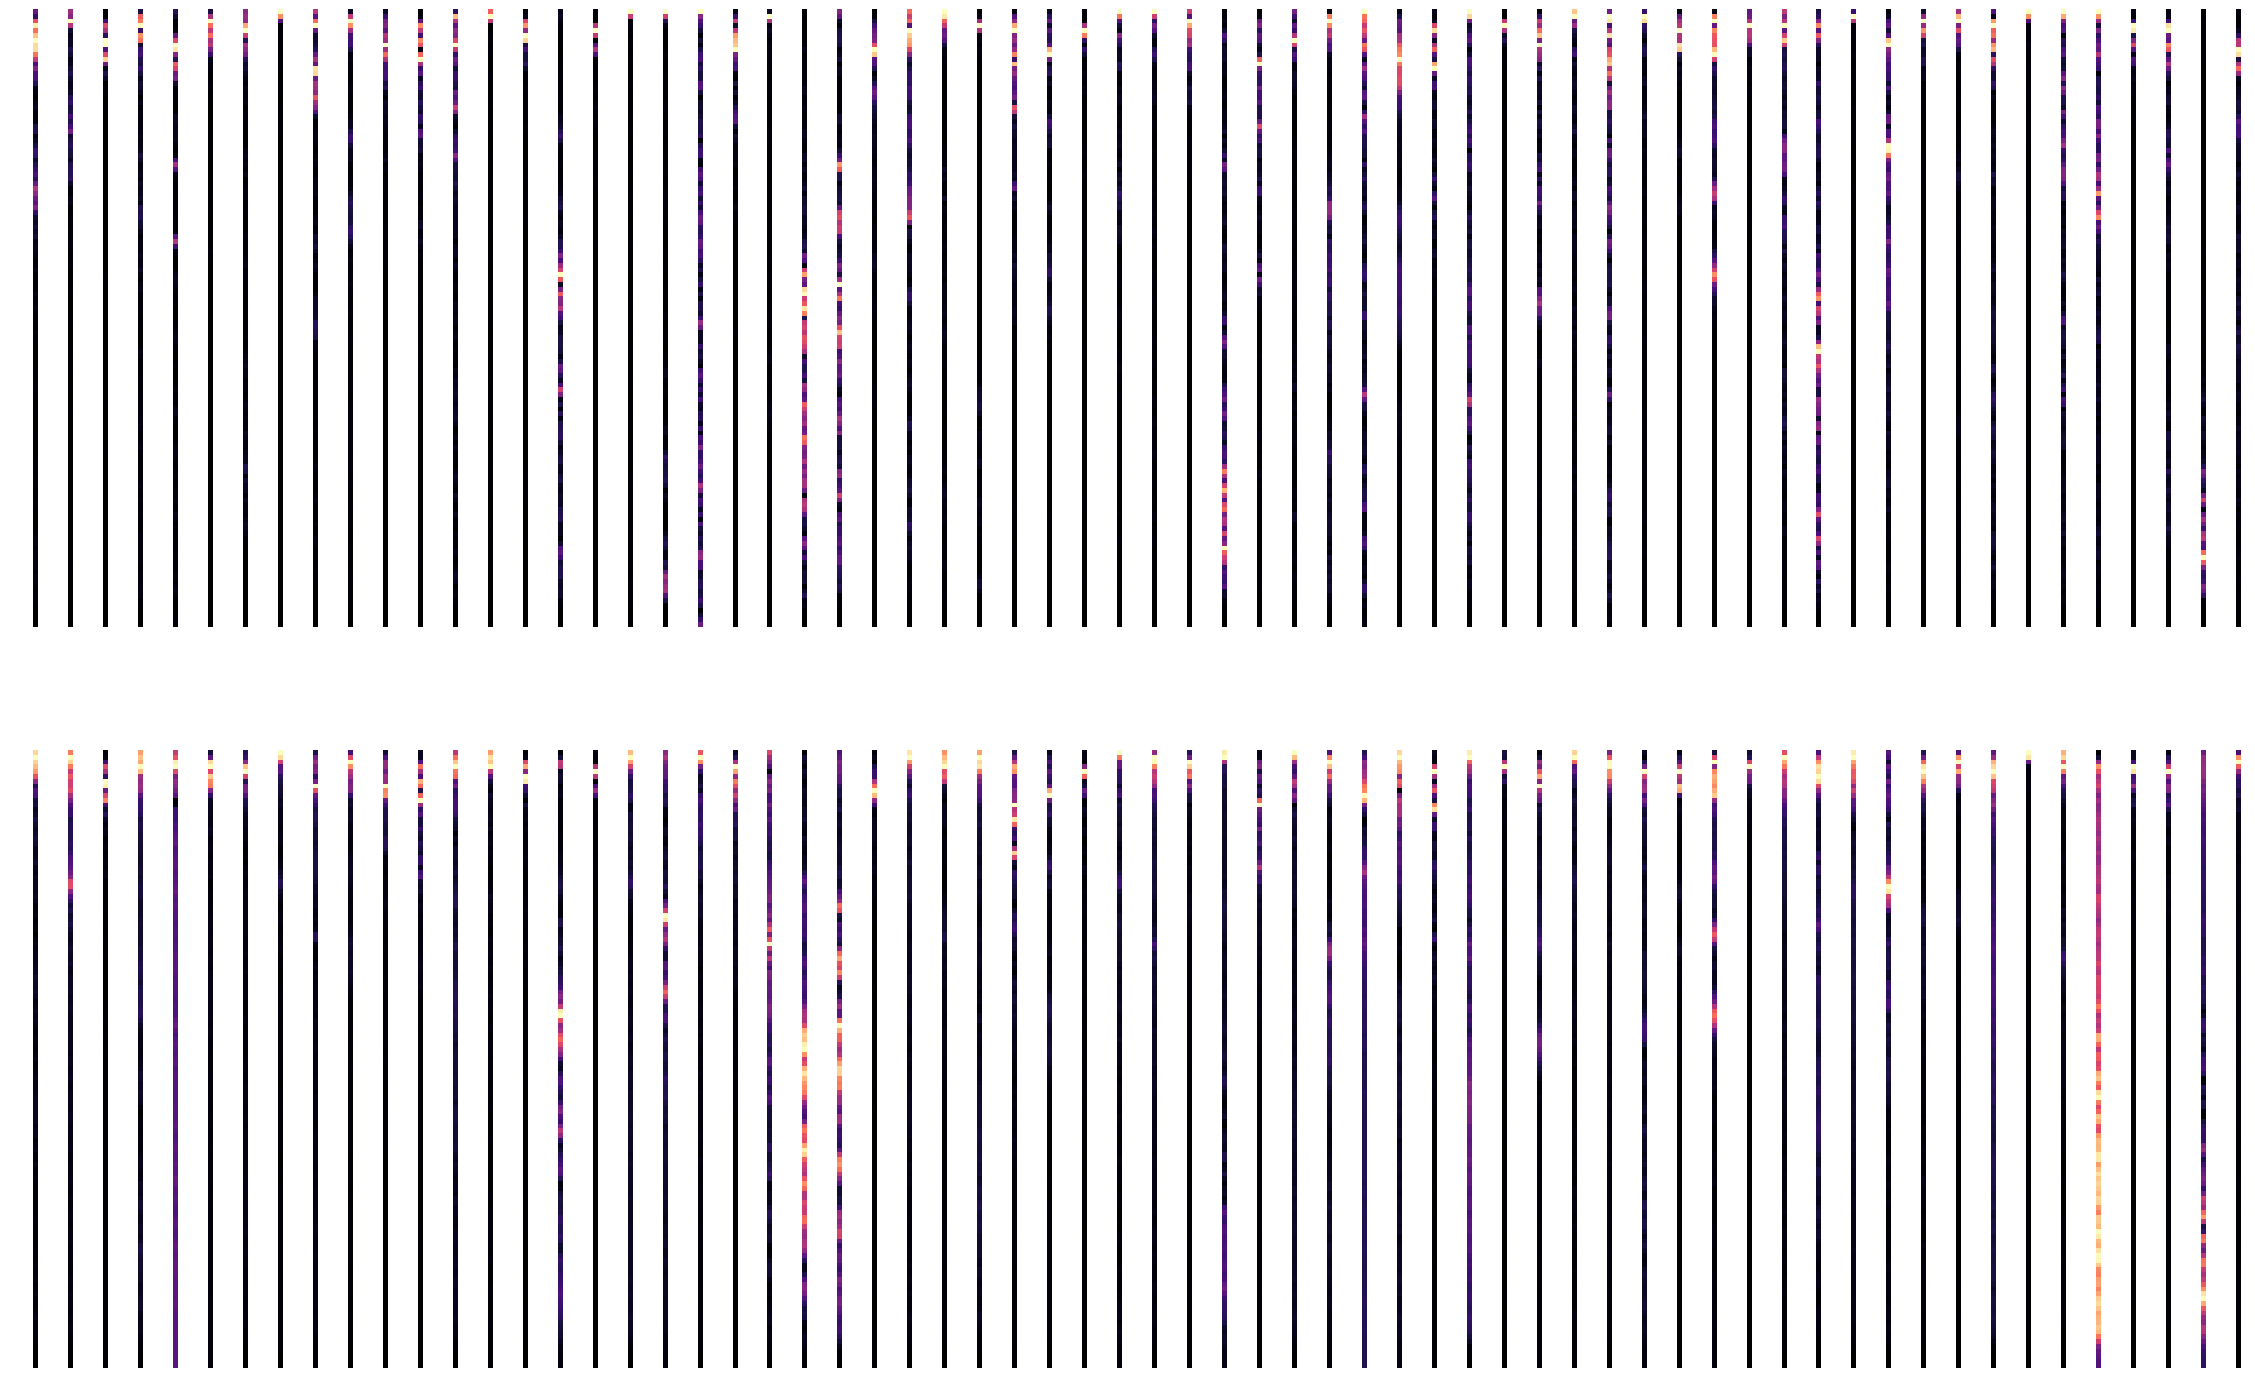

 Epoch 24 , loss 0.069487 , 447 sec (99%).
 Epoch: 24, Test set ELBO: 0.059949398040771484, time elapse for current epoch 505.0651135444641[s]



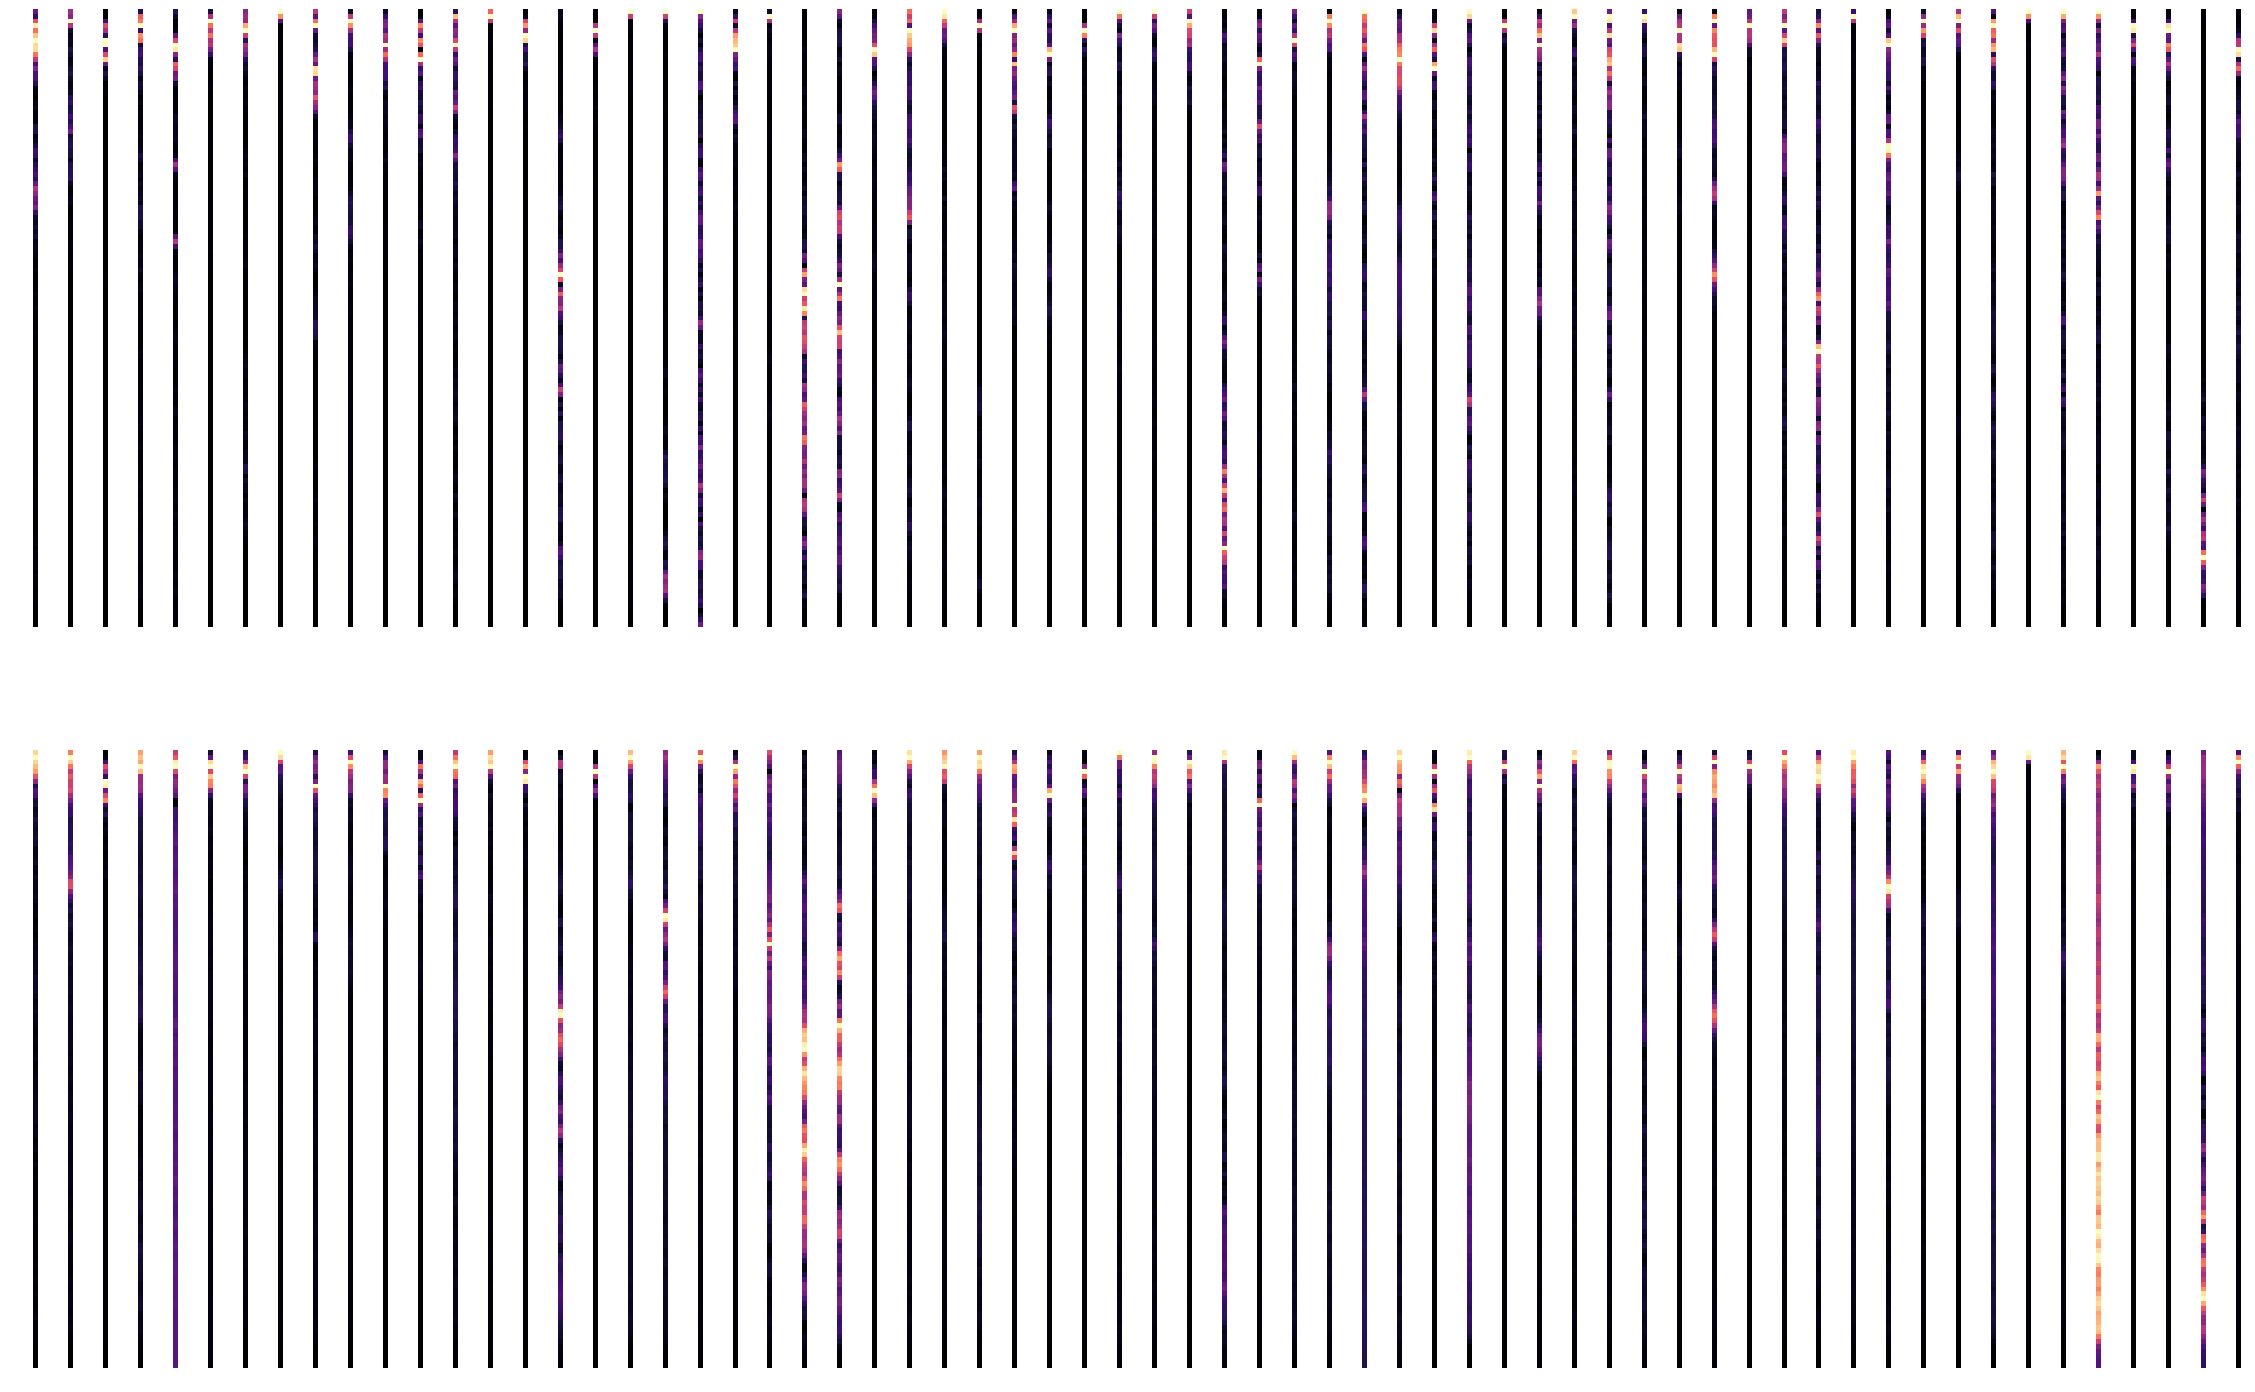

In [5]:
epochs = 12
batch_size = 64
examples_num = 64

training_num = len(train_x_dataset)
training_times = training_num//batch_size
training_perc = training_times//100
testing_num = len(test_x_dataset)
testing_times = testing_num//batch_size
testing_perc = testing_times//100
#model = CVAE(latent_dim, batch_size)
model = DNN(batch_size)
last_epoch = 12
model.load_weights('./weights/my_model_%0d' % last_epoch)

def generate_and_save_images(model, epoch, test_input, test_target):
    predictions, _ = model.noise_reduction(test_input)
    fig = plt.figure(figsize=(40, 25))

    for i in range(predictions.shape[0]):
        plt.subplot(2, examples_num, i + 1)
        plt.imshow(test_target[i, :, :, 0], cmap='magma')
        plt.axis('off')
        plt.subplot(2, examples_num, examples_num + i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='magma')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

batch_buffer_x = np.zeros((batch_size, fft_size, frame_width, 1), dtype=np.float64)
batch_buffer_y1 = np.zeros((batch_size, fft_size, 1, 1), dtype=np.float64)
batch_buffer_y2 = np.zeros((batch_size, fft_size, 1, 1), dtype=np.float64)
testing_rand = np.random.permutation(testing_num)

for epoch in range(last_epoch + 1, epochs + last_epoch + 1):
    start_time = time.time()
    training_rand = np.random.permutation(training_num)
    rand_idx = 0
    for times in range(training_times):
        for idx in range(batch_size):
            batch_buffer_x[idx,:,:,0] = train_x_dataset[training_rand[rand_idx]]
            batch_buffer_y1[idx,:,0,0] = train_y1_dataset[training_rand[rand_idx]][:,0]
            batch_buffer_y2[idx,:,0,0] = train_y2_dataset[training_rand[rand_idx]][:,0]
            rand_idx += 1
        gradients, loss = compute_gradients(model, batch_buffer_x, batch_buffer_y1, batch_buffer_y2)
        apply_gradients(optimizer, gradients, model.trainable_variables)
        if ((times+1) % training_perc) is 0 or (times+1) is training_times:
            print('\r', 
                  'Epoch %d' % epoch,
                  ', loss %f' % loss,
                  ', %d sec' % (time.time() - start_time),
                  '(%d%%).' % (100.0*(times+1)/training_times),
                  end='')
    
    model.save_weights('./weights/my_model_%0d' % epoch)
    
    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        rand_idx = 0
        for times in range(testing_times):
            for idx in range(batch_size):
                batch_buffer_x[idx,:,:,0] = test_x_dataset[testing_rand[rand_idx]]
                batch_buffer_y1[idx,:,0,0] = test_y1_dataset[testing_rand[rand_idx]][:,0]
                batch_buffer_y2[idx,:,0,0] = test_y2_dataset[testing_rand[rand_idx]][:,0]
                rand_idx += 1
            loss(compute_loss(model, batch_buffer_x, batch_buffer_y1, batch_buffer_y2))
        elbo = loss.result()
        #display.clear_output(wait=False)
        print('\n', 
              'Epoch: {}, Test set ELBO: {}, time elapse for current epoch {}[s]\n'.format(epoch,
                                                                                           elbo,
                                                                                           time.time()-start_time))
        generate_and_save_images(
            model, epoch, batch_buffer_x[:examples_num,:,:,0:1], batch_buffer_y1[:examples_num,:,:,0:1])

In [ ]:
# Audio parameter
channel_num = 1
sampling = 16000 #Hz
sampwidth = 2 #byte
frame_size = 256
fft_size = frame_size // 2 + 1
step_ratio = 4
frame_step = frame_size // step_ratio
frame_width = 7
frame_center = 3

int2float = 32768.0
train_rate = 0.8
data_len = len(fnmatch.filter(os.listdir(dataset_merge_speech_dir), '*.wav'))
train_len = int(data_len * train_rate)
rand_data = np.random.permutation(data_len)
train_idx = rand_data[:train_len]
test_idx = rand_data[train_len:]
hann_in = np.hanning(frame_size) * 2.0  / int2float

buffer_x_abs = np.zeros((fft_size, frame_width*2), dtype=np.float64)
buffer_x_ang = np.zeros((fft_size, frame_width*2), dtype=np.complex128)
hann_out = np.hanning(frame_size) * int2float / 1.5
sub_speech_idx = 0

end_epoch = 24
model = DNN(1)
model.load_weights('./weights/my_model_%0d' % end_epoch)

for idx in range(data_len):
    mix_name = 'mix_librivox_%05d.wav' % idx
    merge_mix_dir = os.path.join(dataset_merge_mix_dir, mix_name)
    merge_mix_wave = wave.open(merge_mix_dir, "rb")
    merge_mix_params = merge_mix_wave.getparams()
    merge_mix_nchannels, merge_mix_sampwidth, merge_mix_framerate, merge_mix_nframes = merge_mix_params[:4]
    merge_mix_strData = merge_mix_wave.readframes(merge_mix_nframes)
    merge_mix_Data = np.fromstring(merge_mix_strData, dtype=np.int16)
    merge_mix_wave.close()
    
    separate_speech_Data = np.zeros(merge_mix_Data.shape, dtype=np.int16)
    separate_noise_Data = np.zeros(merge_mix_Data.shape, dtype=np.int16)
        
    frame_length = merge_mix_nframes//frame_step - step_ratio + 1
    for step in range(frame_length):
        sample = step * frame_step
        sub_idx = step % frame_width
        merge_mix_frame = merge_mix_Data[sample:sample + frame_size]
        mix_sp = np.fft.fft(hann_in * merge_mix_frame)
        buffer_x_abs[:,sub_idx] = np.absolute(mix_sp[:fft_size])
        buffer_x_abs[:,frame_width+sub_idx] = buffer_x_abs[:,sub_idx]
        buffer_x_ang[:,sub_idx] = mix_sp[:fft_size] / buffer_x_abs[:,sub_idx]
        buffer_x_ang[:,frame_width+sub_idx] = buffer_x_ang[:,sub_idx]
        
        y1_abs, y2_abs = model.noise_reduction(buffer_x_abs[:,sub_idx:frame_width+sub_idx].reshape([1, fft_size, frame_width, 1]))
        y1_out = tf.reshape(y1_abs, [fft_size]) * buffer_x_ang[:,sub_idx+frame_center]
        y2_out = tf.reshape(y2_abs, [fft_size]) * buffer_x_ang[:,sub_idx+frame_center]
        y1_frame = np.zeros((frame_size), dtype=np.complex128)
        y2_frame = np.zeros((frame_size), dtype=np.complex128)
        y1_frame[:fft_size] = y1_out
        y2_frame[:fft_size] = y2_out
        y1_frame[fft_size:frame_size] = np.conjugate(y1_out[fft_size-2:0:-1])
        y2_frame[fft_size:frame_size] = np.conjugate(y2_out[fft_size-2:0:-1])
        y1_f = np.fft.ifft(y1_frame, axis=0)
        y2_f = np.fft.ifft(y2_frame, axis=0)
        separate_speech_Data[sample: sample + frame_size] += (hann_out * y1_f).real.astype(np.int16)
        separate_noise_Data[sample: sample + frame_size] += (hann_out * y2_f).real.astype(np.int16)
            
    #打開WAV文檔
    #speech_basename = os.path.basename(speech_name)
    speech_basename = 'librivox'

    #切割後的speech
    separate_speech_name = 'separate_speech_' + speech_basename + '_%05d' % sub_speech_idx + '.wav'
    separate_speech_dir = os.path.join(dataset_separate_speech_dir, separate_speech_name)
    separate_speech_wave = wave.open(separate_speech_dir, "wb")
    #配置聲道數、量化位數和取樣頻率
    separate_speech_wave.setnchannels(merge_mix_nchannels) 
    separate_speech_wave.setsampwidth(merge_mix_sampwidth) 
    separate_speech_wave.setframerate(merge_mix_framerate) 
    #將wav_data轉換為二進制數據寫入文件
    separate_speech_wave.writeframes(separate_speech_Data.tostring()) 
    separate_speech_wave.close()

    #切割後的noise
    separate_noise_name = 'separate_noise_' + speech_basename + '_%05d' % sub_speech_idx + '.wav'
    separate_noise_dir = os.path.join(dataset_separate_noise_dir, separate_noise_name)
    separate_noise_wave = wave.open(separate_noise_dir, "wb")
    #配置聲道數、量化位數和取樣頻率
    separate_noise_wave.setnchannels(merge_mix_nchannels) 
    separate_noise_wave.setsampwidth(merge_mix_sampwidth) 
    separate_noise_wave.setframerate(merge_mix_framerate) 
    #將wav_data轉換為二進制數據寫入文件
    separate_noise_wave.writeframes(separate_noise_Data.tostring()) 
    separate_noise_wave.close()

    sub_speech_idx += 1

W0501 23:48:17.541783 17348 base.py:270] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x000002619426C240> and <tensorflow.python.keras.layers.core.Reshape object at 0x000002619426CC88>).
W0501 23:48:17.546770 17348 base.py:270] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x0000026195945908> and <tensorflow.python.keras.layers.core.Reshape object at 0x0000026195945A90>).
W0501 23:48:17.550760 1734